## Initialize HW and constants

In [1]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network
import yig_controller_test


plt.rcParams['figure.figsize'] = [15, 10]

#Instruments and devices
yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)



Waiting for init... Done


In [6]:
#Constants and auxillary functions
fMin=np.array([0.55, 1, 2, 4, 8, 12])*1e9
fMax=np.array([1,    2, 4, 8, 12, 16])*1e9
hardwareDescription='Yig filters moved to source side of transistor'
hardwareRevision='2.1'

def revFileName(baseName):
    global hardwareRevision
    return '%s_rev_%s.mat'%(baseName, hardwareRevision)

def saveData(baseName, baseData):
    global hardwareDescription
    global hardwareRevision
    dataToSave=baseData;
    dataToSave['hardwareDescription']=hardwareDescription
    sio.savemat(revFileName(baseName), dataToSave)

def loadData(baseName):
    global hardwareRevision
    return sio.loadmat(revFileName(baseName))
    

## Measure current tuning ranges

In [3]:
wr = np.linspace(-32768, 32767, 128, dtype=np.int16)
yigChs = range(6)

zeros = []
channels=[]
currentMtx = None;
for c in yigChs:
    yc.yigA.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yc.yigA.set(c, w);
        time.sleep(0.5)
        for i in range(3):
            curMeter.readValue()
        current.append(curMeter.readValue())
    channels.append(current)
    currentMtx = yig_controller_test.stackVector(currentMtx, current)
    yc.yigA.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())

saveData('current_sweep', {'current':currentMtx, 'yigChs':yigChs, 'tuningWordRange': wr});


In [4]:
import scipy.io as sio
saveData('yig_filter_driver_current_data', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [7]:
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [8]:
print(zeros)

[-1.4e-05 -1.4e-05 -1.5e-05 -1.6e-05 -1.9e-05 -1.9e-05]


Filter 0 has current from 0.006483 to 0.081909 [A] in control word range -22448 - 32250 [LSB]
Filter 1 has current from 0.019077 to 0.240909 [A] in control word range -22448 - 32250 [LSB]
Filter 2 has current from 0.022427 to 0.282632 [A] in control word range -22448 - 32250 [LSB]
Filter 3 has current from 0.044726 to 0.479346 [A] in control word range -22448 - 23478 [LSB]
Filter 4 has current from 0.088681 to 1.113829 [A] in control word range -22448 - 32250 [LSB]
Filter 5 has current from 0.088889 to 0.835579 [A] in control word range -22448 - 17286 [LSB]


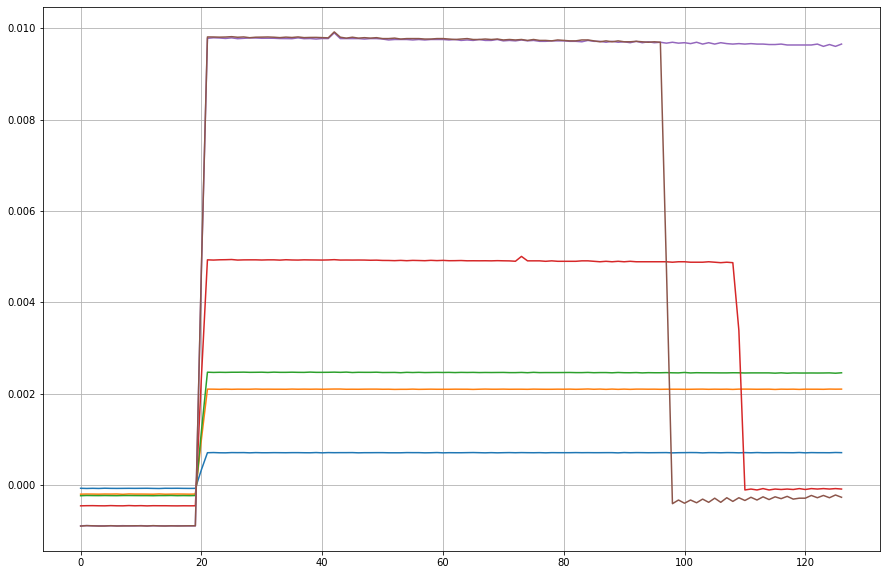

In [9]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    #avgd = moving_average(np.diff(charr[i,:]), 10)
    avgd = np.diff(charr[i,:])
    plt.plot(avgd)
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

## Coarse tuning

Filter 0
[0.00000e+00 9.93500e+07 1.98700e+08 1.98700e+08 1.49025e+08 1.98700e+08
 1.98700e+08]
Filter 1
[4.47075e+08 5.96100e+08 5.46425e+08 5.96100e+08 5.46425e+08 5.96100e+08
 4.96750e+08]
Filter 2
[-8.94150e+08  6.95450e+08  5.96100e+08  6.95450e+08  6.45775e+08
  6.45775e+08  6.45775e+08]
Filter 3
[9.935000e+08 1.092850e+09 1.092850e+09 1.092850e+09 1.092850e+09
 1.092850e+09 1.043175e+09]
Filter 4
[2.384400e+09 2.583100e+09 2.583100e+09 2.583100e+09 2.583100e+09
 2.583100e+09 2.533425e+09]
Filter 5
[2.136025e+09 2.285050e+09 2.185700e+09 2.235375e+09 2.185700e+09
 2.235375e+09 2.185700e+09]
0.428050 to 1.471225 [GHz]
0.477725 to 4.302700 [GHz]
1.073825 to 4.998150 [GHz]
0.875125 to 8.376050 [GHz]
1.769275 to 19.602600 [GHz]
1.918300 to 17.367225 [GHz]


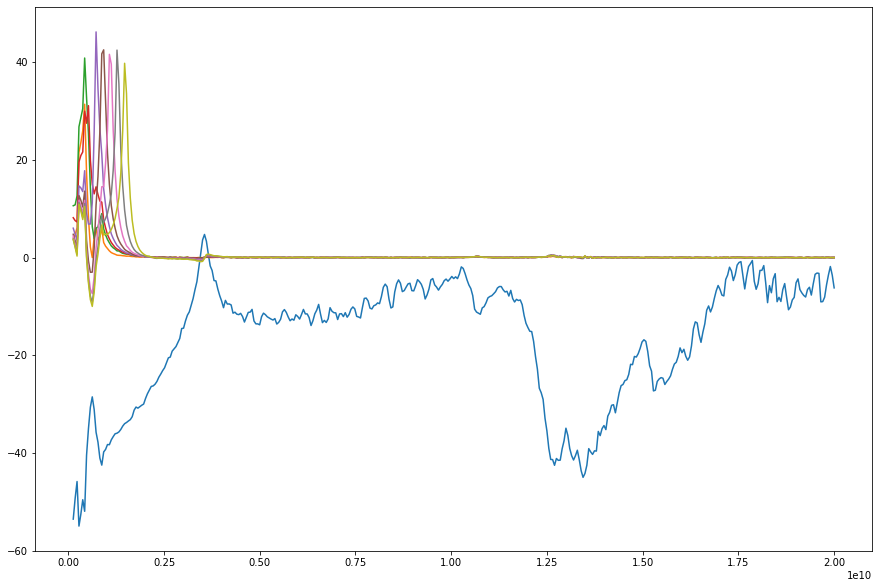

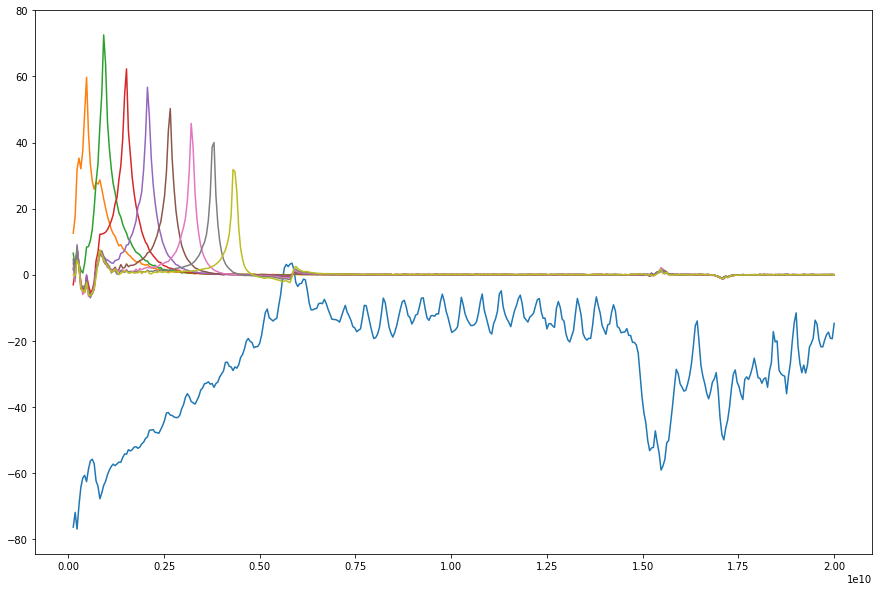

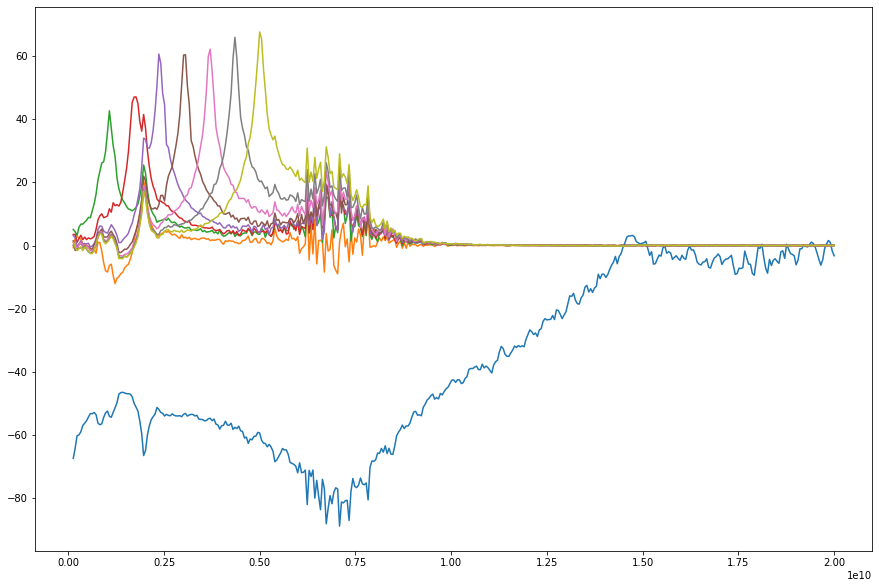

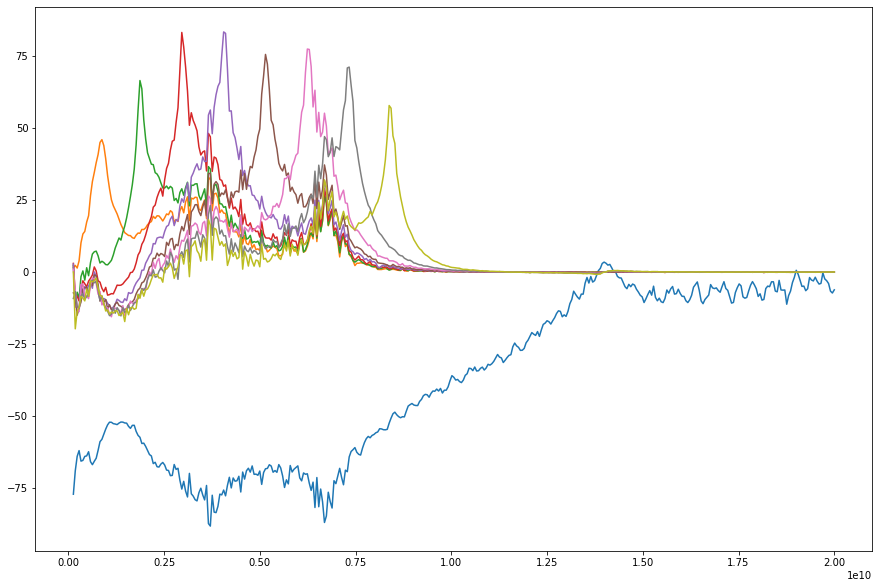

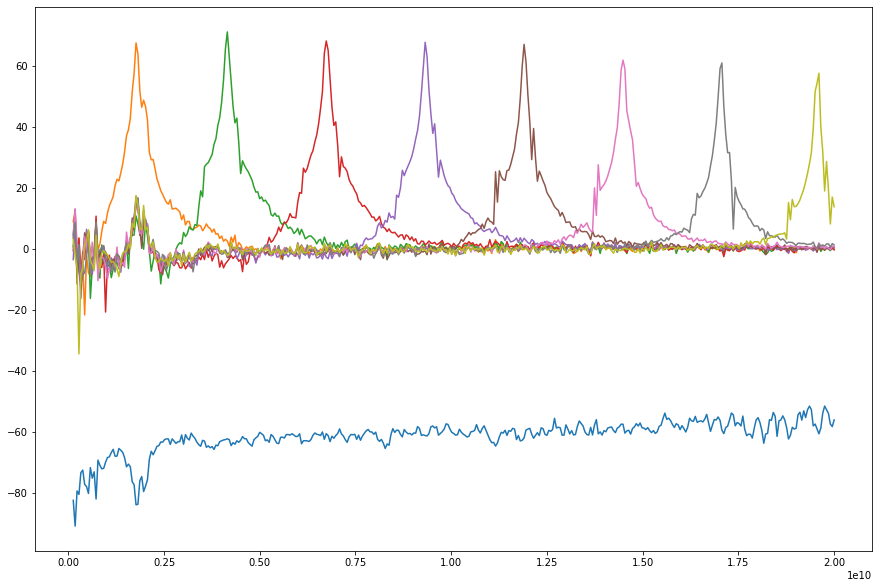

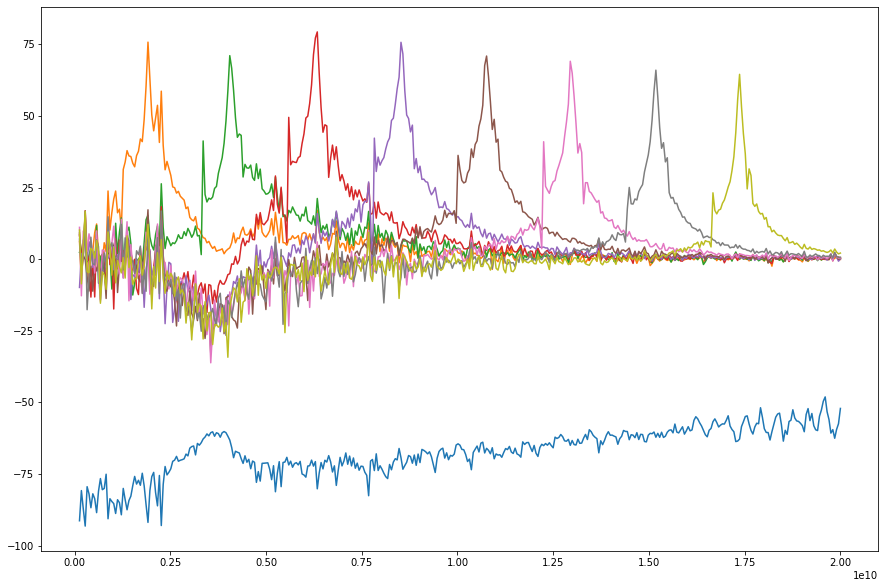

<Figure size 1080x720 with 0 Axes>

In [10]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    print("Filter", i )
    fp = fParams[i]
    yc.switchA.set(i+1)
    yc.yigA.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yc.yigA.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        #traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
saveData('yig_filter_driver_coarse_frequency', {'fRanges':fRanges})

In [11]:
#Get calibration data
import os.path

if not os.path.exists('cal_through.s2p'):
    calPar=vna.getHighResolutionNetwork(130e6, 20e9, 1e6)
    calPar.plot_s_db()
    calPar.write_touchstone('cal_through.s2p')

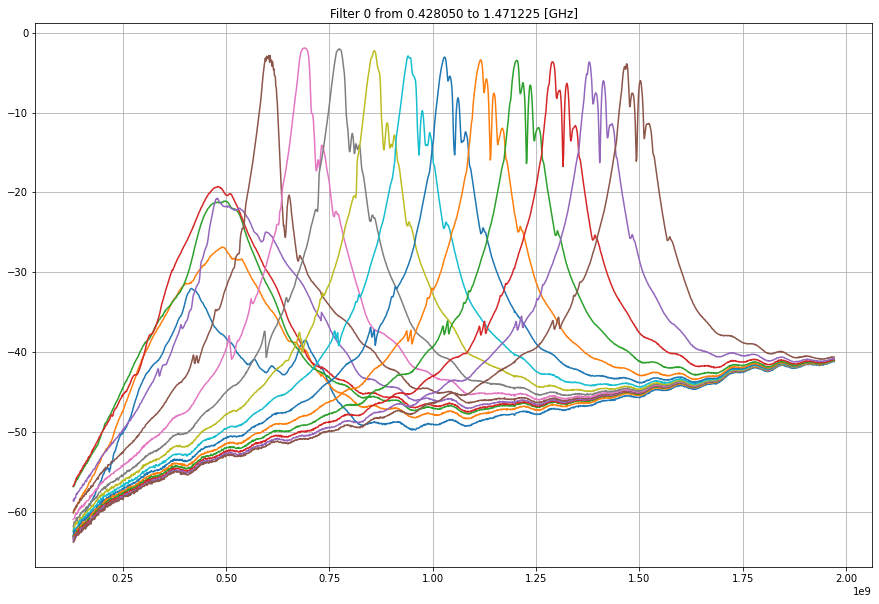

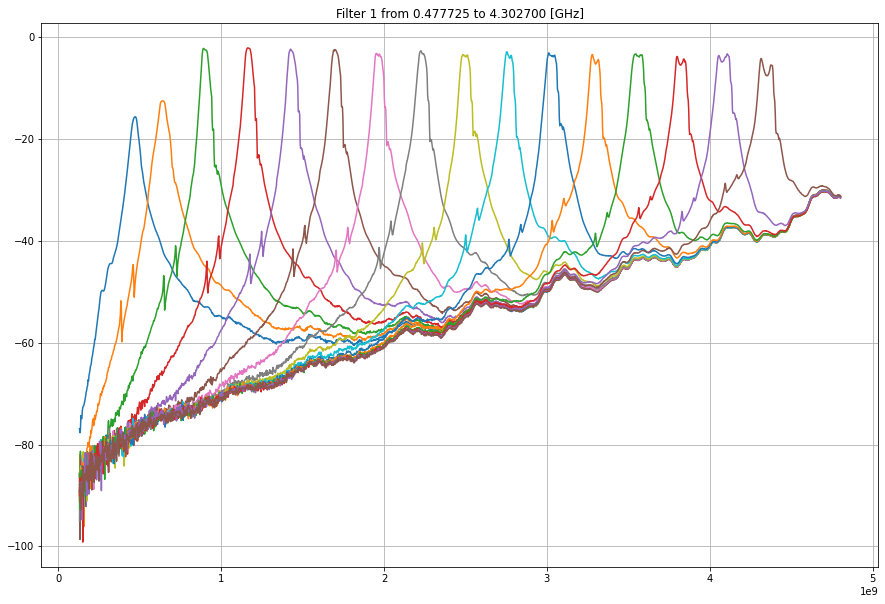

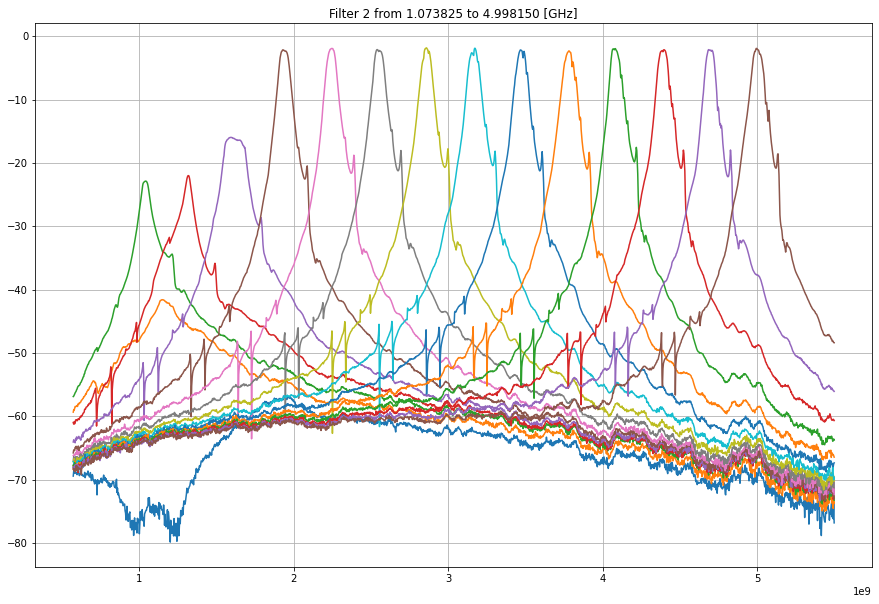

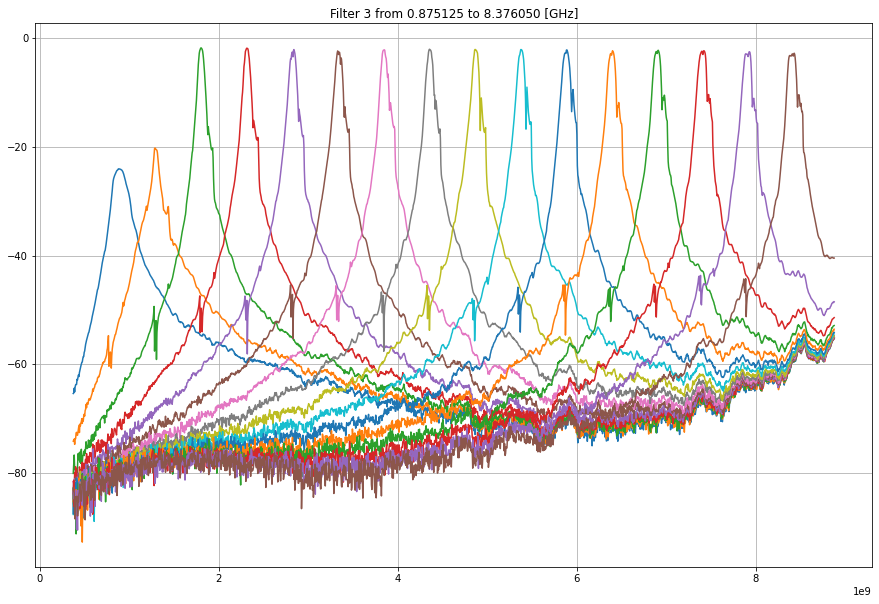

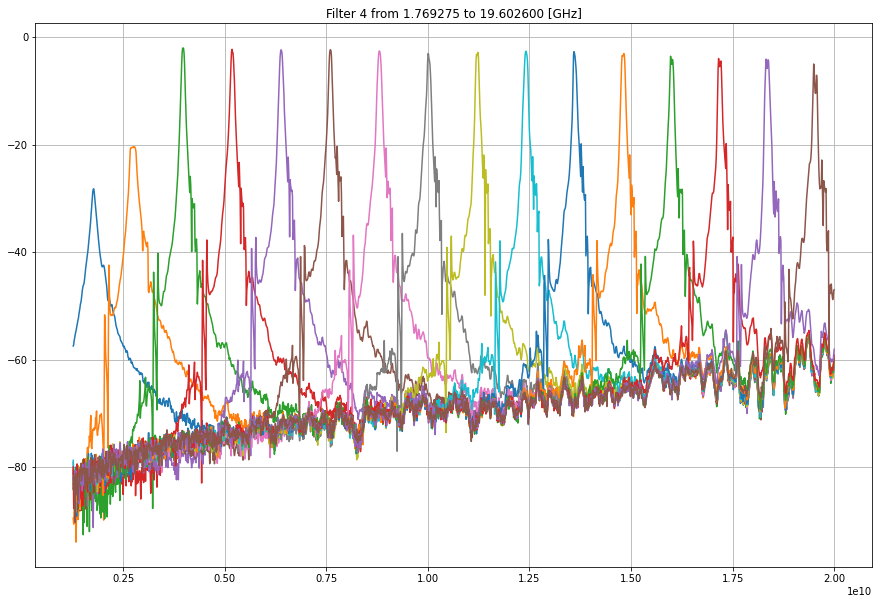

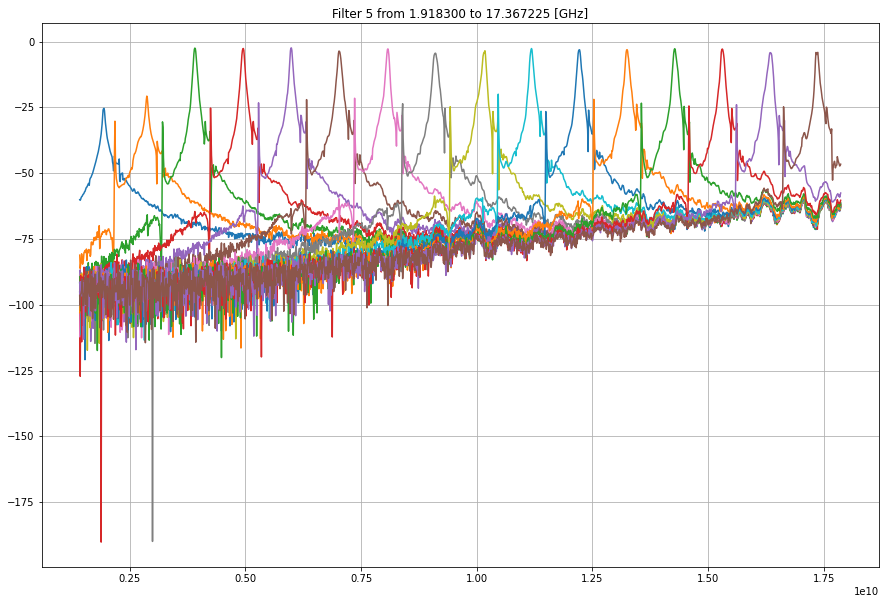

In [12]:
import skrf.network

calPar=skrf.network.Network('cal_through.s2p')
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

d2=loadData('yig_filter_driver_coarse_frequency')
fRanges=d2['fRanges']
#print(fRanges)
#print(channels)
#print(wr)

def inter(fd, fa, a):
    afd=np.interp(fd, fa, a)
    return afd
    
filterMeas={}
for i in range(len(zeros)):
    yc.switchA.set(i+1)
    fsta=fRanges[i,0]-500e6
    fsta=np.max((fsta, 130e6))
    fsto=fRanges[i,1]+500e6
    fsto=np.min((fsto, 20e9))
    vna.setStartFrequency(fsta)
    vna.setStopFrequency(fsto)
    vna.setPoints(1601)
    vwr = np.linspace(fParams[i].lw, fParams[i].hw, 16)
    plt.figure()
    plt.title("Filter %d from %f to %f [GHz]"%(i, fRanges[i,0]/1e9, fRanges[i,1]/1e9))
    thisFilterMeas={}
    thisFilterMeas['words']=[]
    thisFilterMeas['traces']=[]
    thisFilterMeas['frequencies']=[]
    thisFilterMeas['calData']=[]
    for w in vwr:
        yc.yigA.set(i, int(w))
        time.sleep(0.5)
        tr = vna.readSParameter('S21')
        fr = vna.frequencies()
        cai=inter(fr, calPar.f, np.abs(calPar.s[:,1,0]))
        #nf, npar = norm(calPar.f, np.abs(calPar.s[:,0,1]), fr, np.abs(tr))
        #plt.plot(nf, npar)
        plt.plot(fr, 20*np.log10(np.abs(tr)/cai))
        thisFilterMeas['words'].append(w)
        thisFilterMeas['traces'].append(tr)
        thisFilterMeas['frequencies'].append(fr)
        thisFilterMeas['calData'].append(cai)
        #plt.plot(fr, cai)
    filterMeas[i] =  thisFilterMeas
    plt.grid(True)
    plt.show()
    yc.yigA.set(6, 0)    
    

In [13]:

kvec=[]
mvec=[]
for i in range(len(zeros)):
    thisFilter=filterMeas[i]
    words = thisFilter['words']
    traces = thisFilter['traces']
    frequencies = thisFilter['frequencies'][0]
    cals = thisFilter['calData']
    fildat=[]
    for trace, w, cal in zip(traces, words, cals):
        tDat = 20*np.log10(np.abs(trace)/np.abs(cal))
        i=np.argmax(tDat)
        if(tDat[i]>-5):
            fildat.append((int(w), frequencies[i]/1e6, tDat[i]))

    j=int(len(fildat)/5.0)
    jj=int(4*len(fildat)/5.0)
    m=int((j+jj)/2)
    dw=fildat[jj][0]-fildat[j][0]
    df=fildat[jj][1]-fildat[j][1]
    filK=df/dw
    ms=[]
    for m in range(len(fildat)):
        filM=fildat[m][1]-fildat[m][0]*filK
        ms.append(filM)
    filM=np.mean(ms)
    print("Filter parameter for filter %d is k %.3f [MHz/LSB] m is %.3f[LSB]"%(i, filK, filM))
    kvec.append(filK)
    mvec.append(filM)

coarseFilter={'k':kvec, 'm':mvec}
saveData('coarse_filter_parameters', coarseFilter)
        

Filter parameter for filter 1164 is k 0.024 [MHz/LSB] m is 701.389[LSB]
Filter parameter for filter 1433 is k 0.072 [MHz/LSB] m is 2000.431[LSB]
Filter parameter for filter 1437 is k 0.085 [MHz/LSB] m is 2280.412[LSB]
Filter parameter for filter 1516 is k 0.166 [MHz/LSB] m is 4527.880[LSB]
Filter parameter for filter 1557 is k 0.329 [MHz/LSB] m is 8980.192[LSB]
Filter parameter for filter 1552 is k 0.391 [MHz/LSB] m is 10631.035[LSB]


## Measure drift

Measuring filter 0


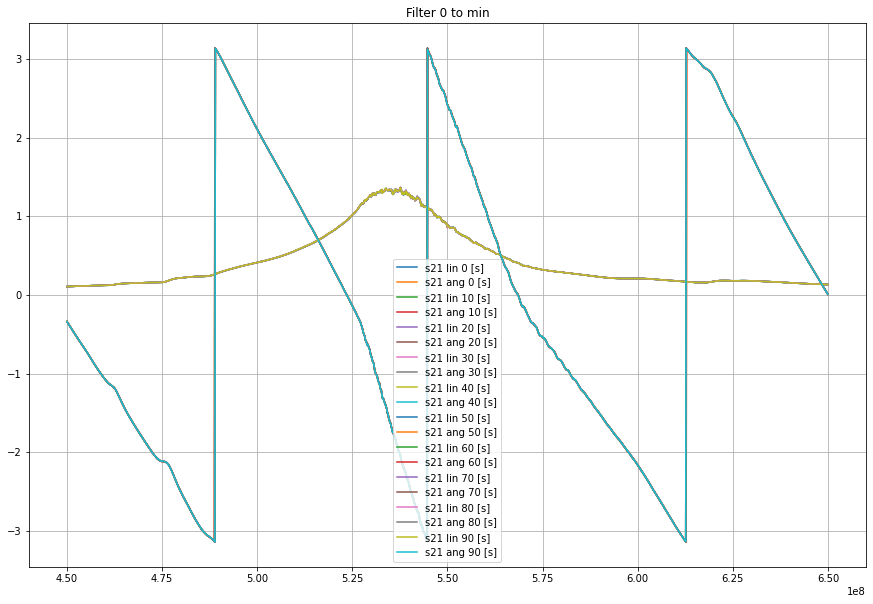

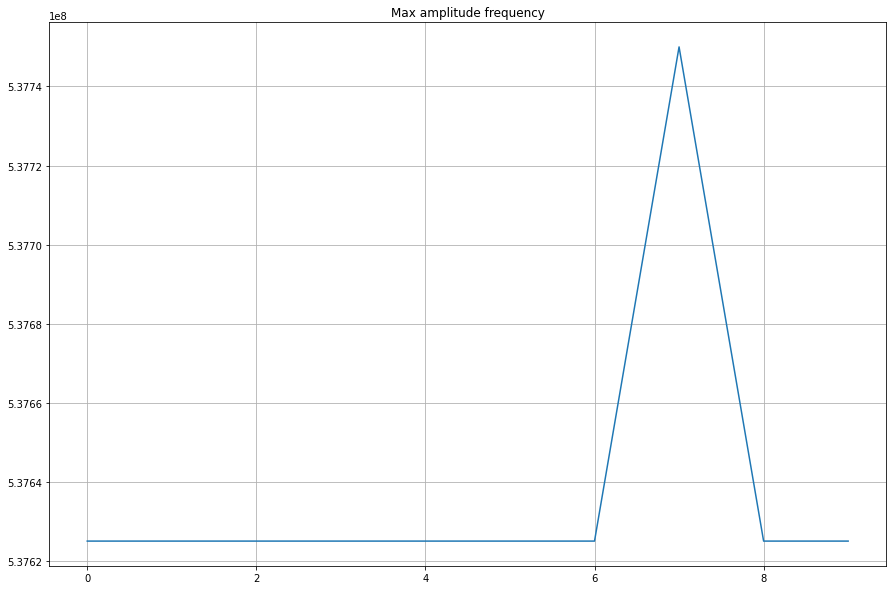

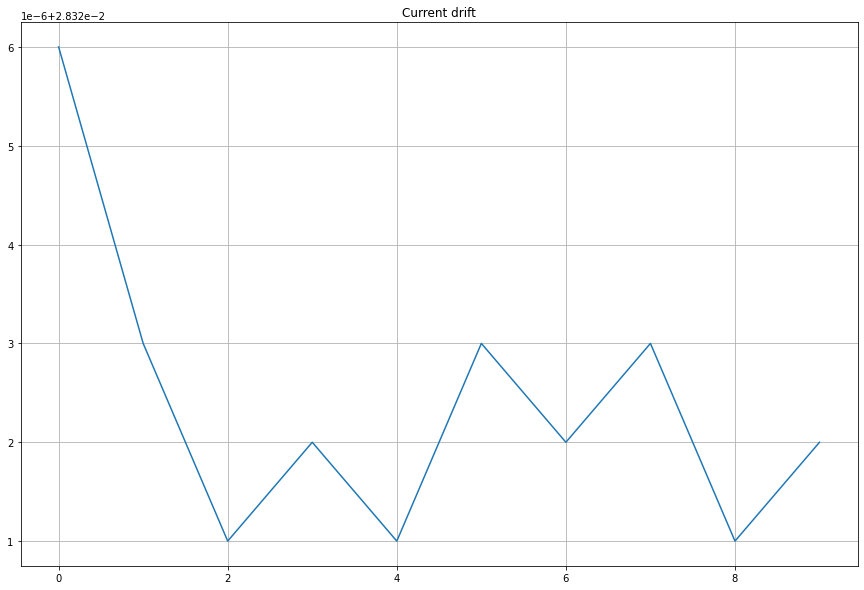

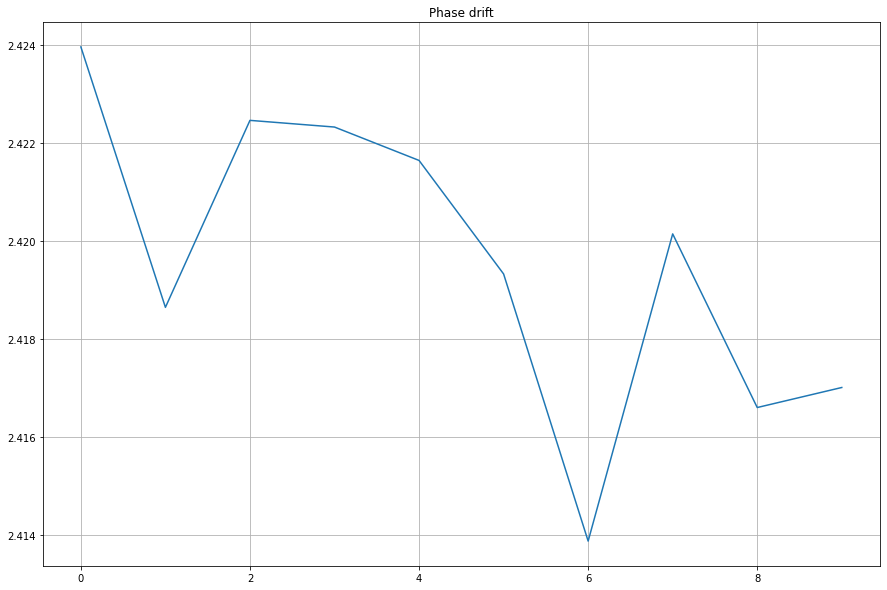

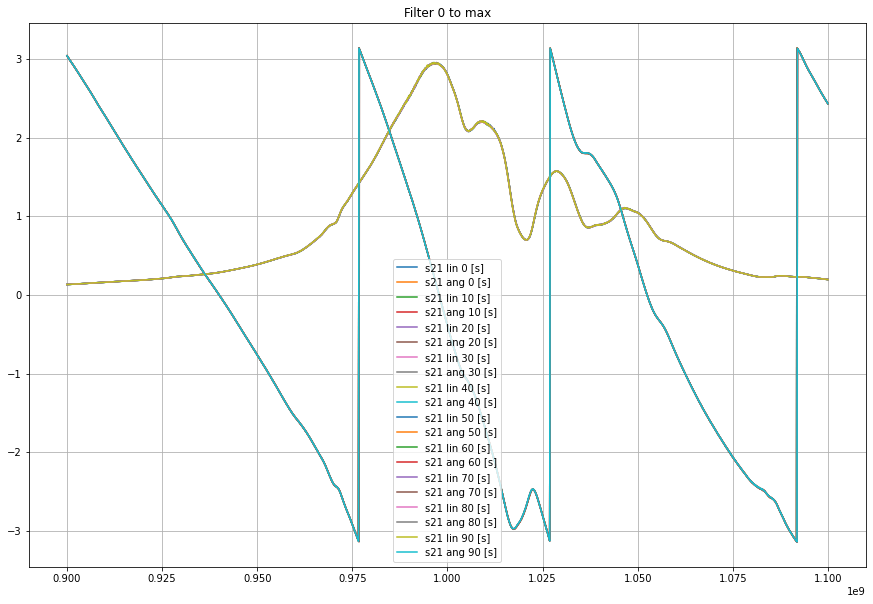

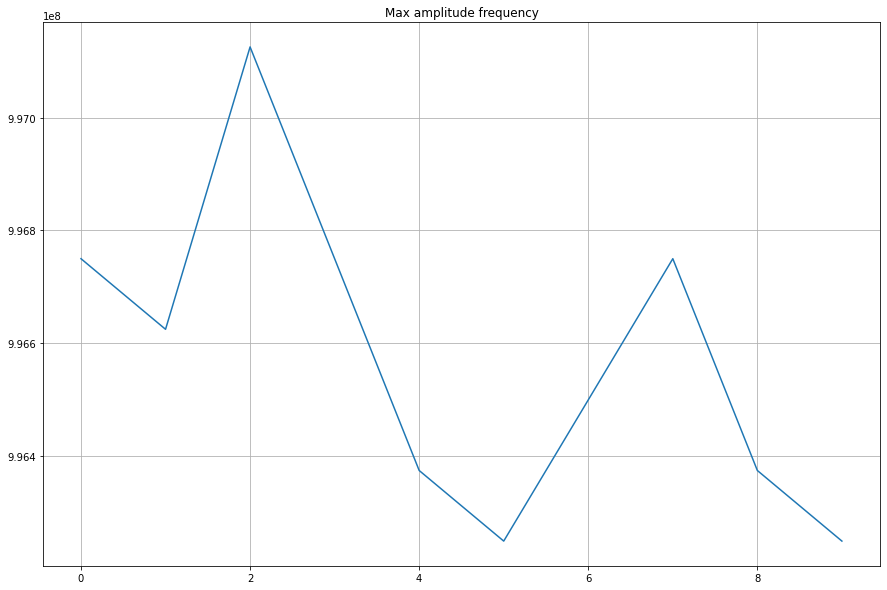

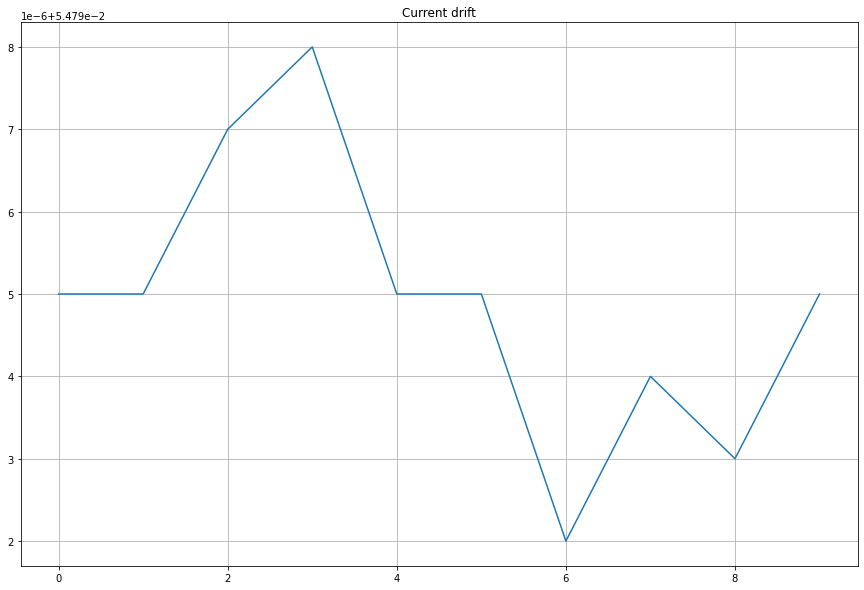

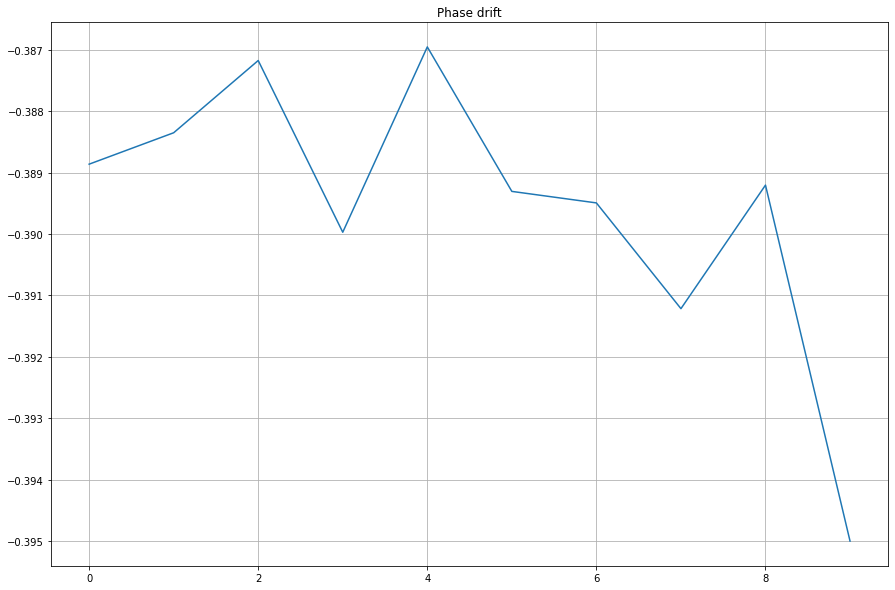

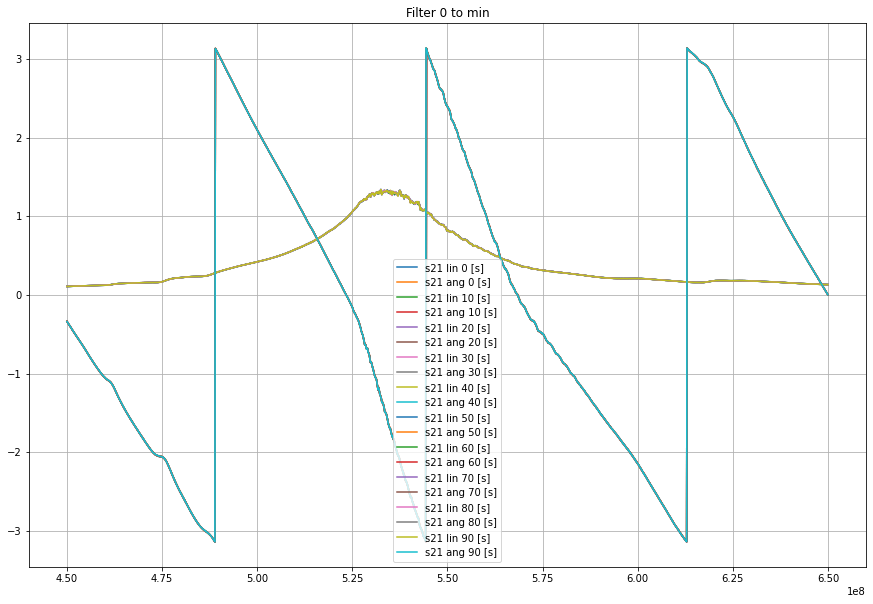

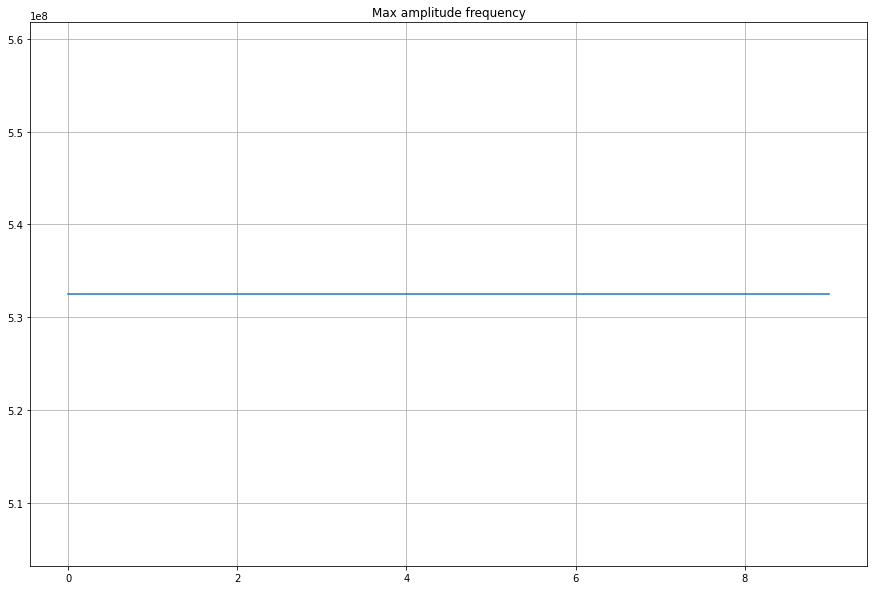

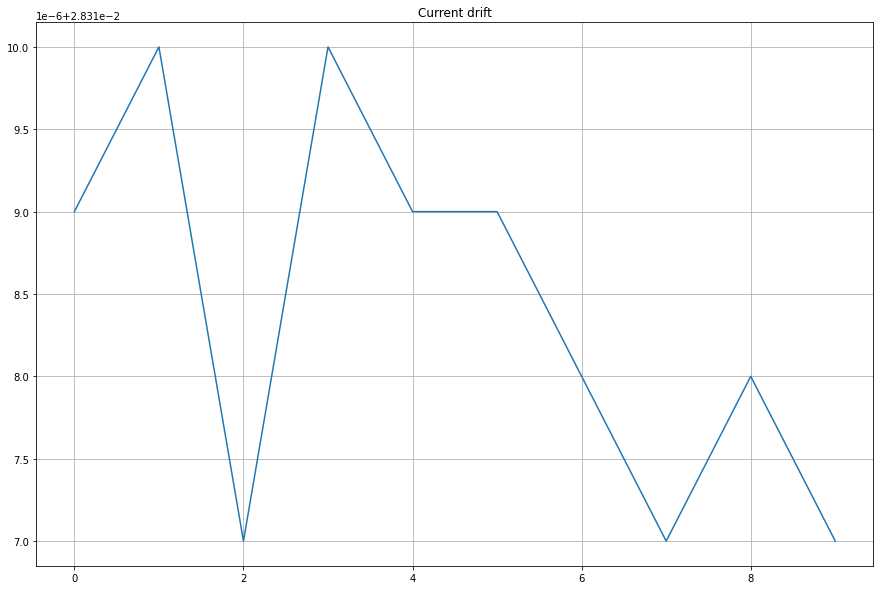

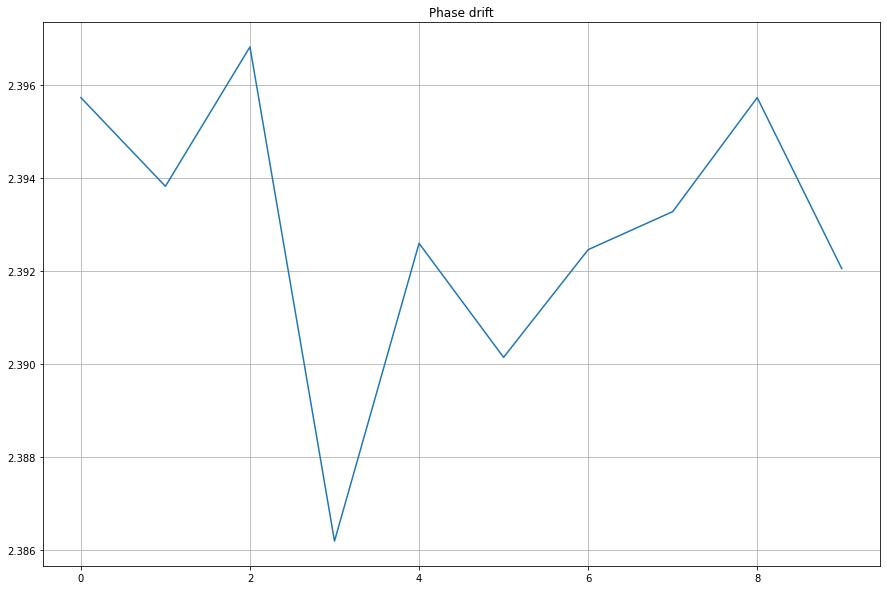

Measuring filter 1


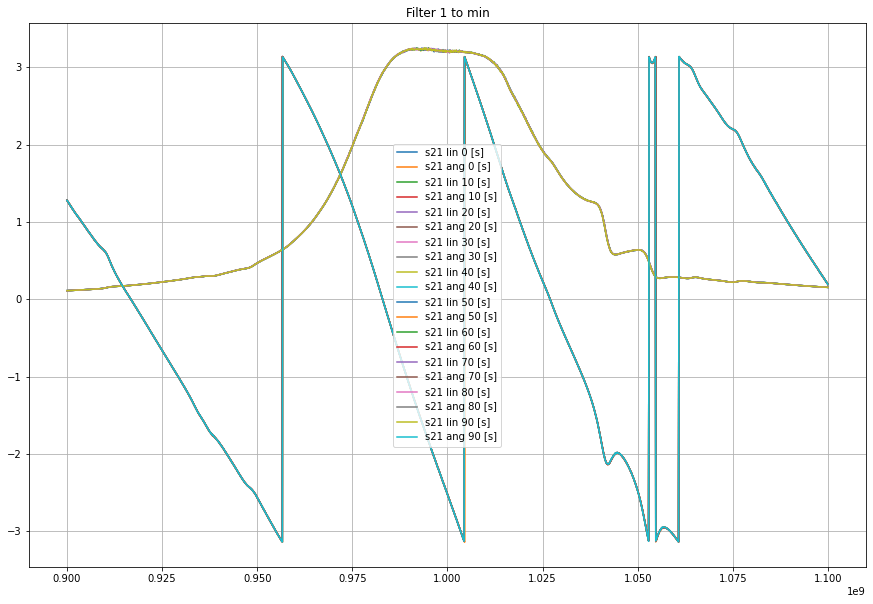

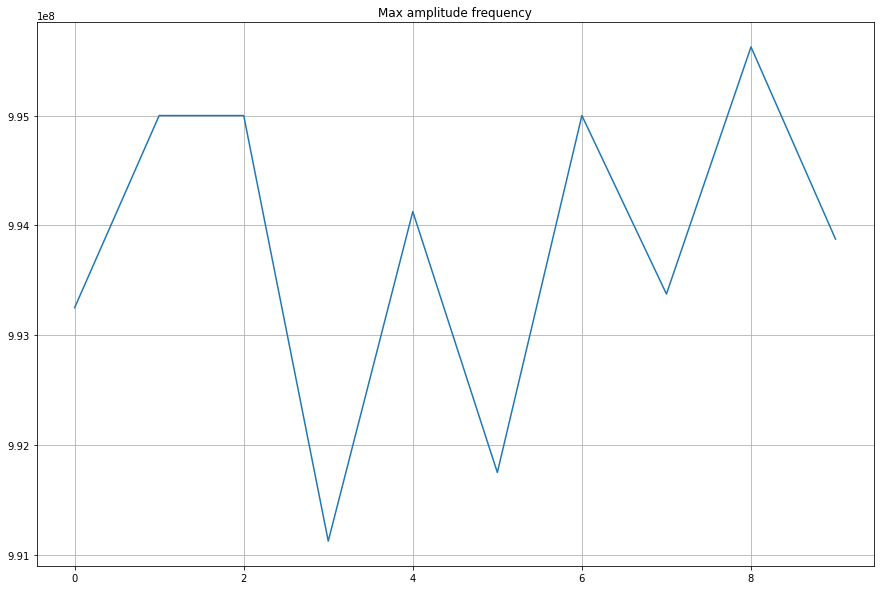

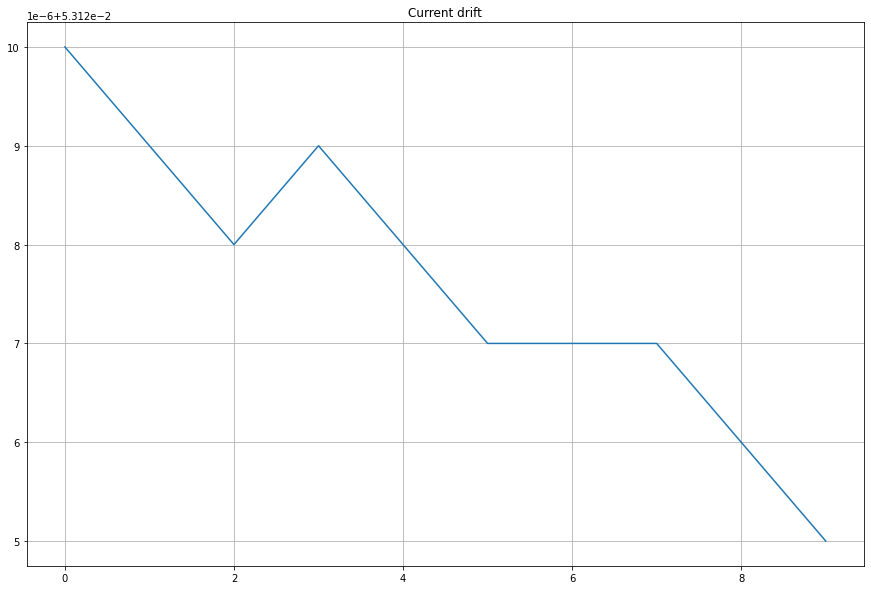

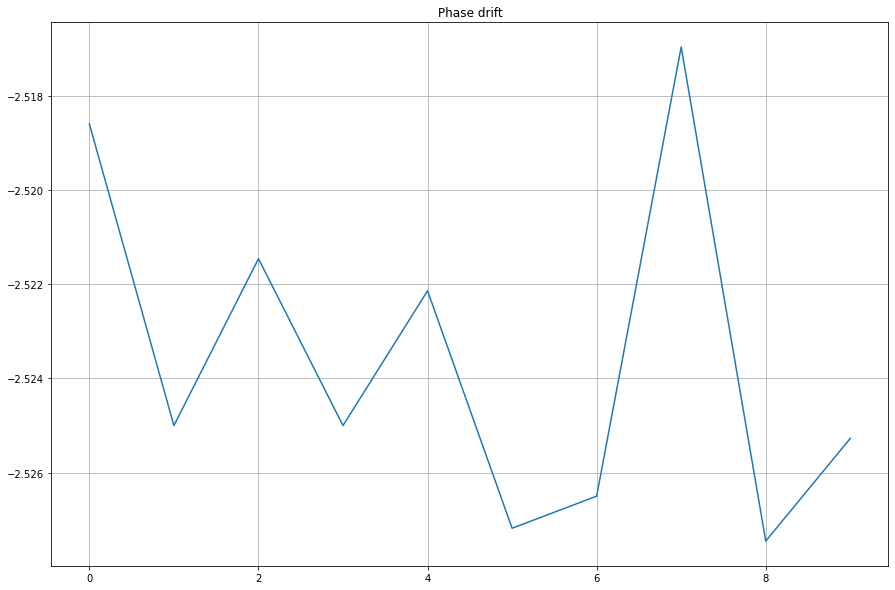

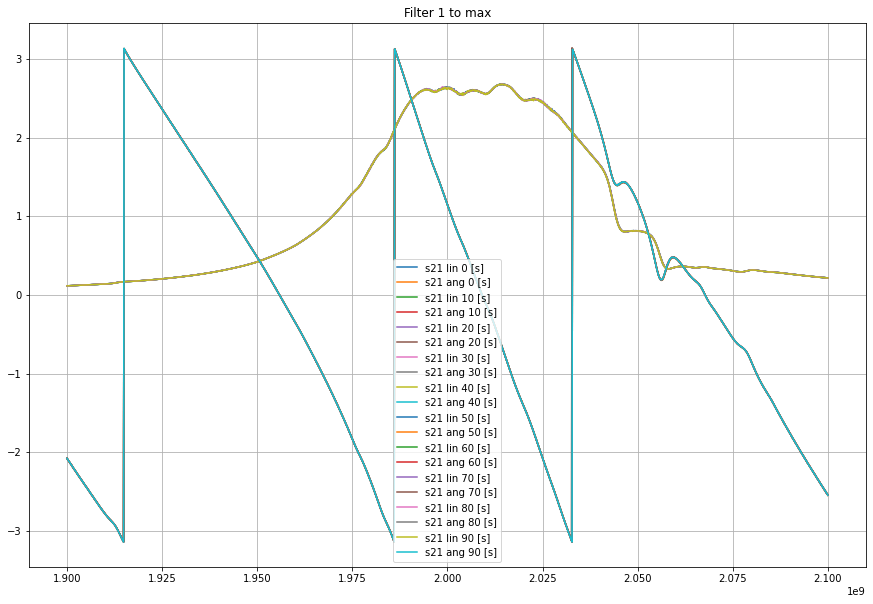

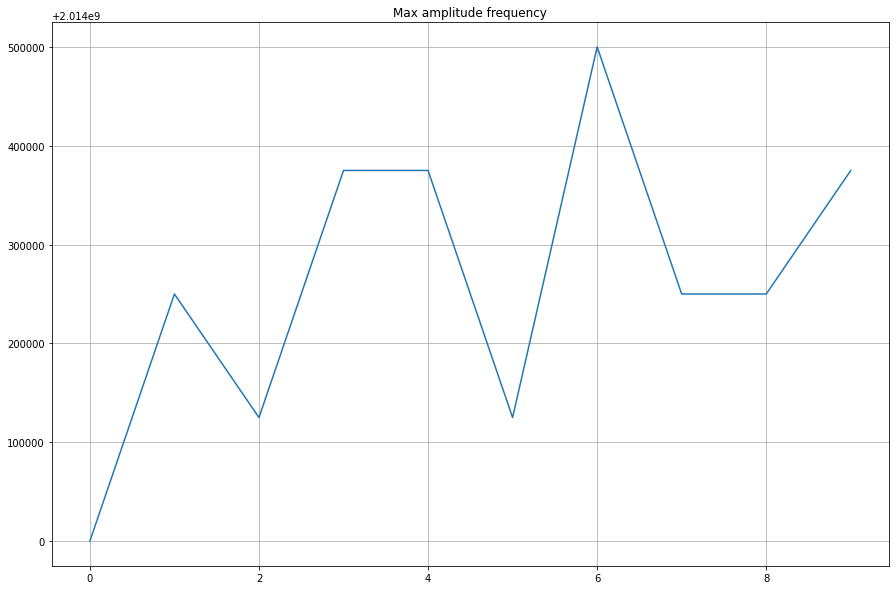

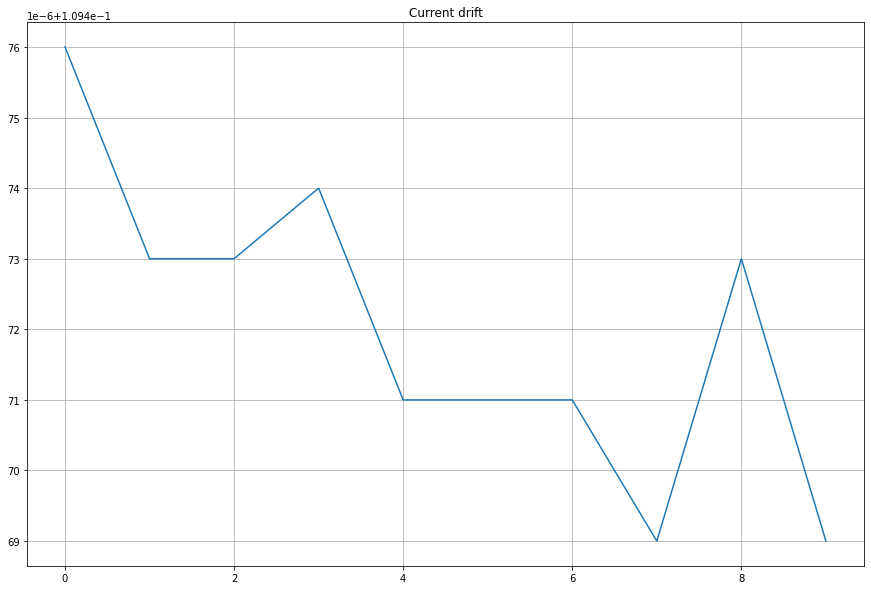

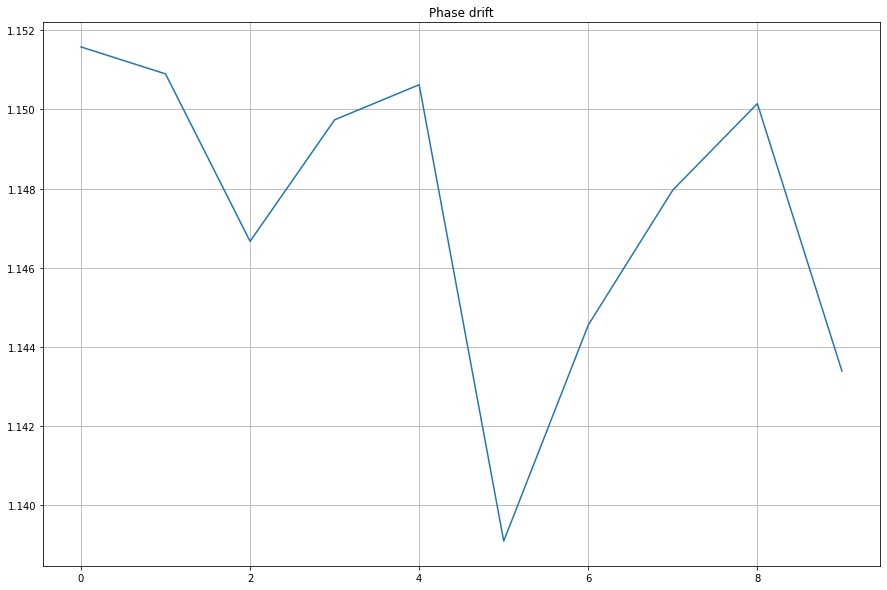

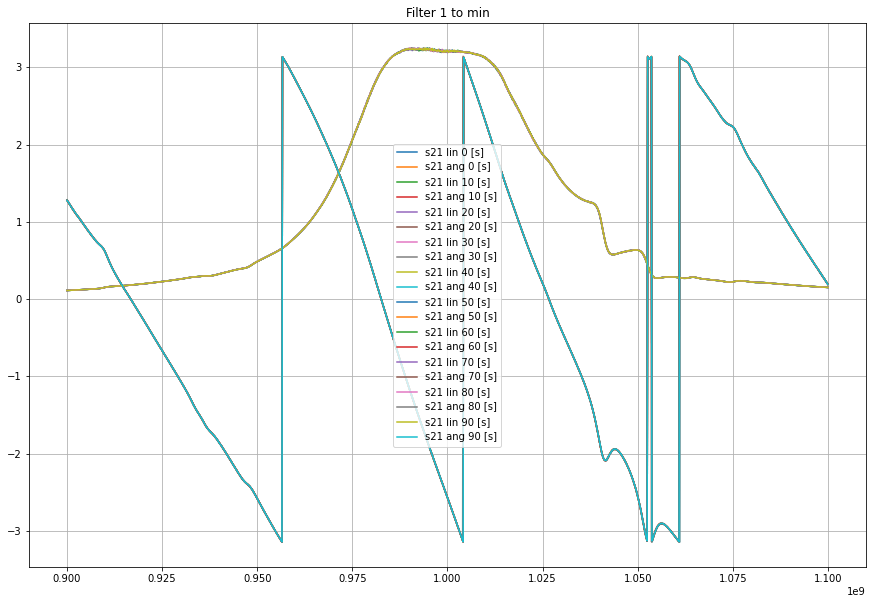

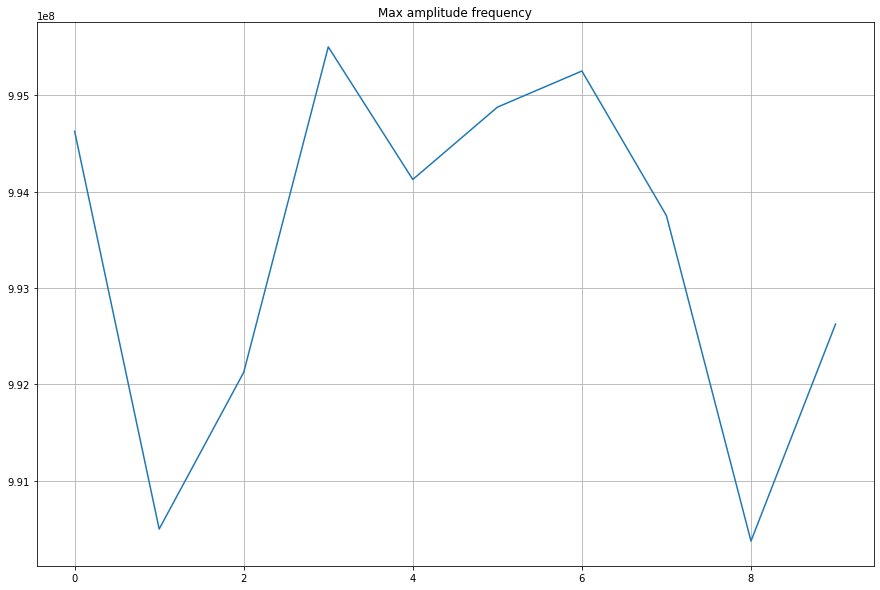

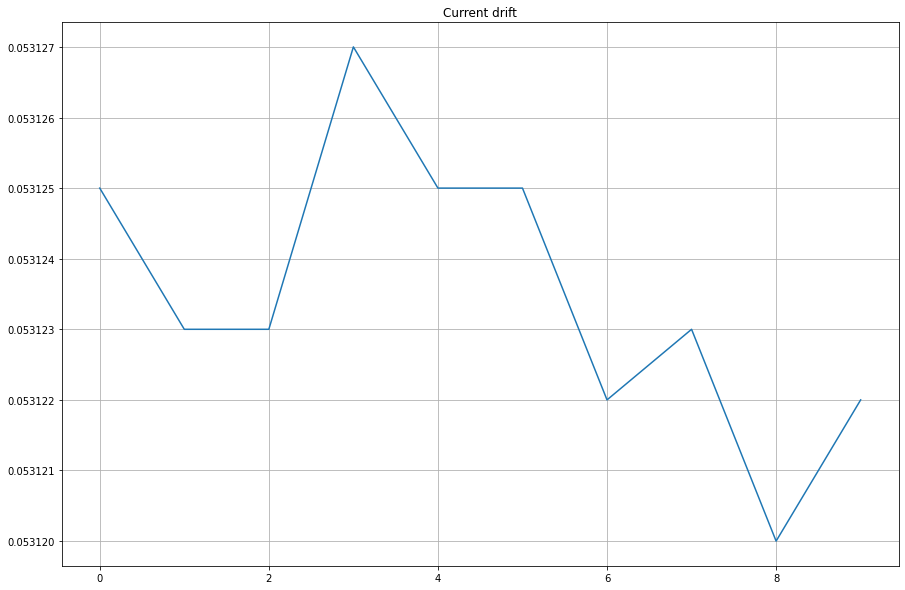

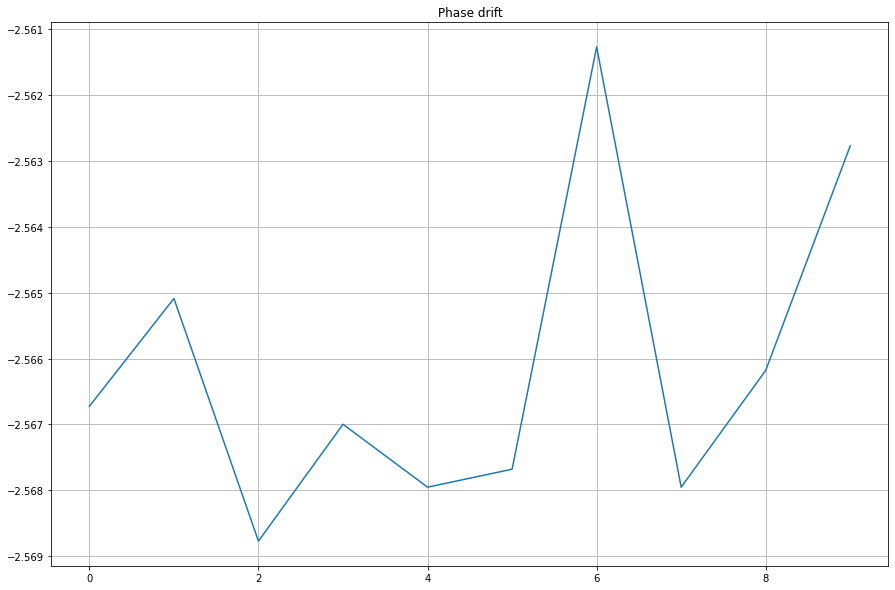

Measuring filter 2


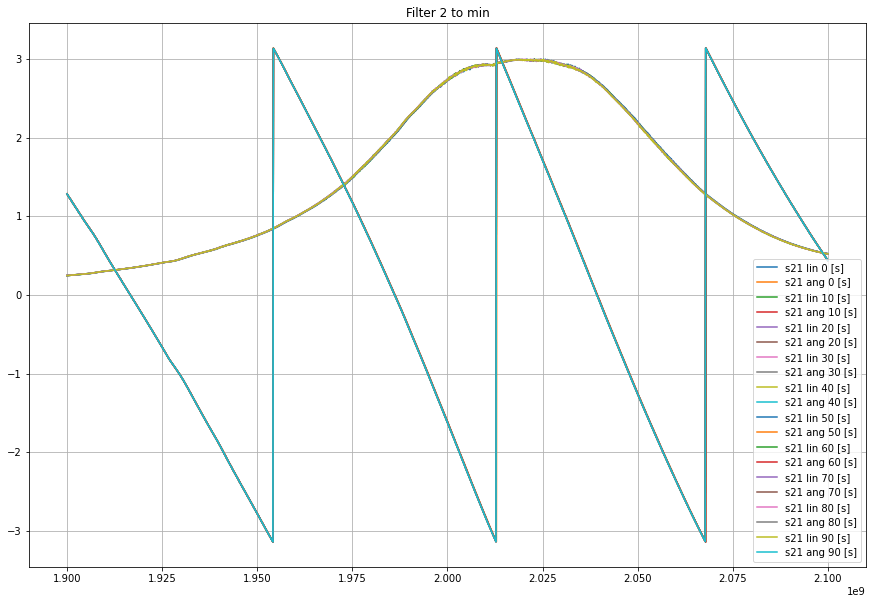

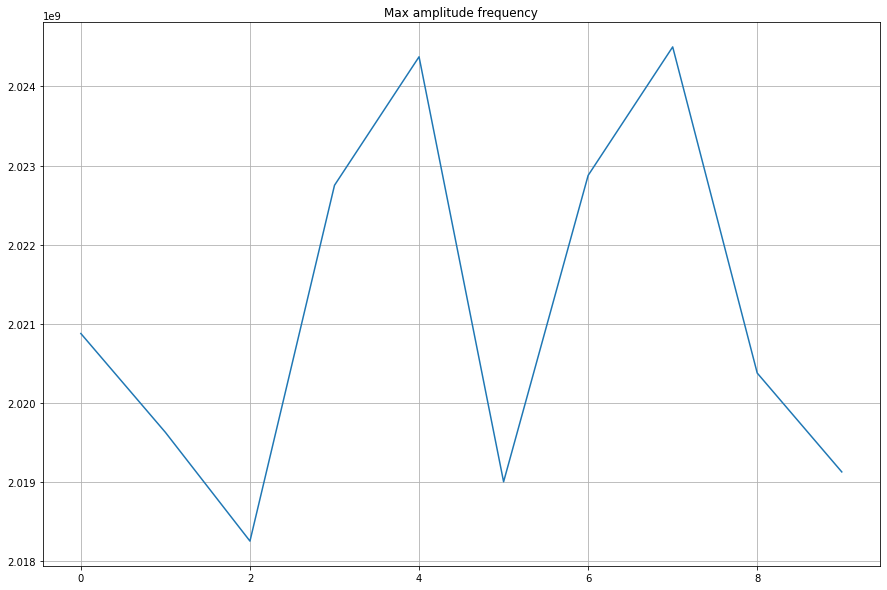

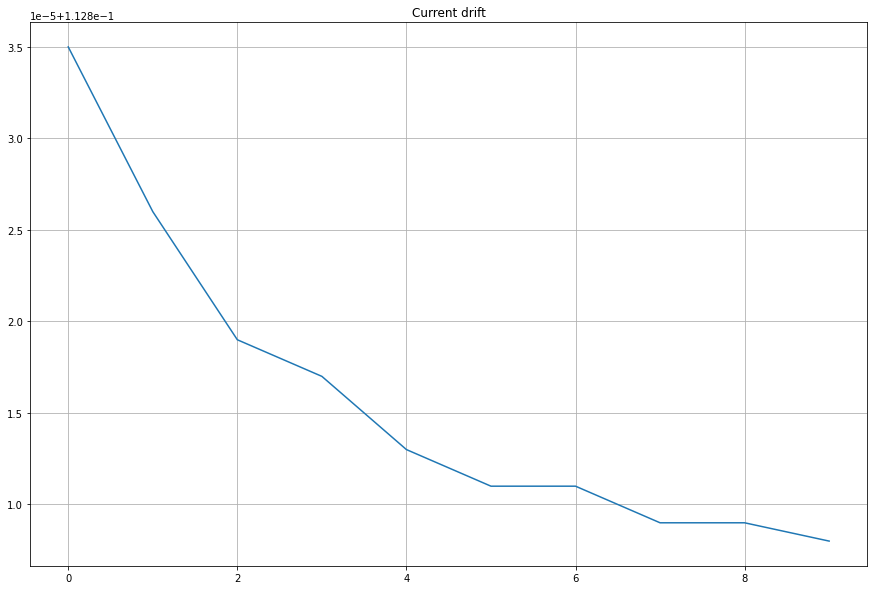

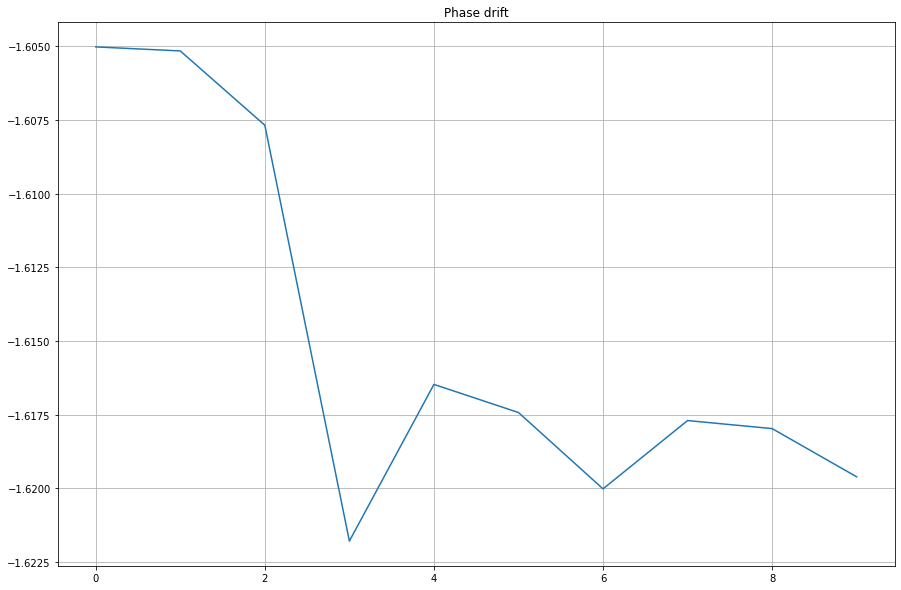

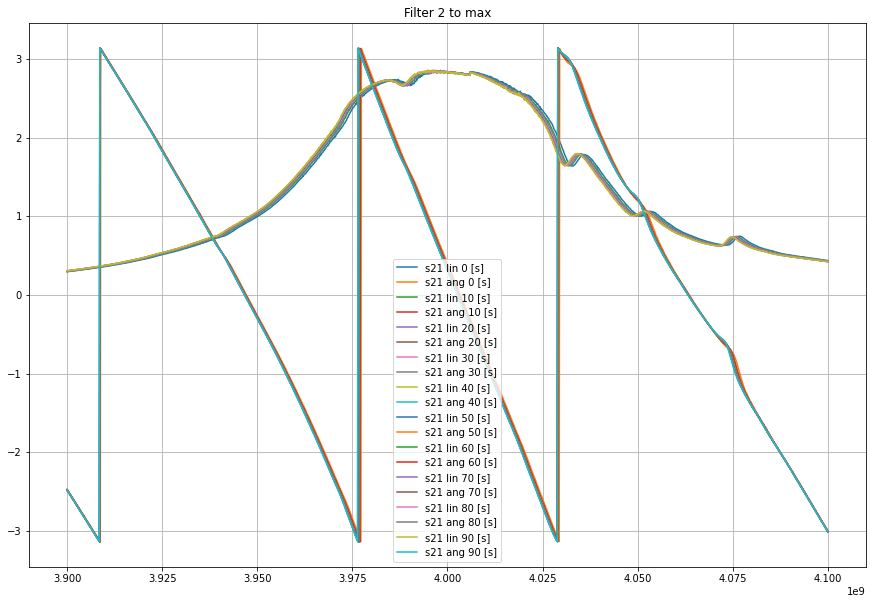

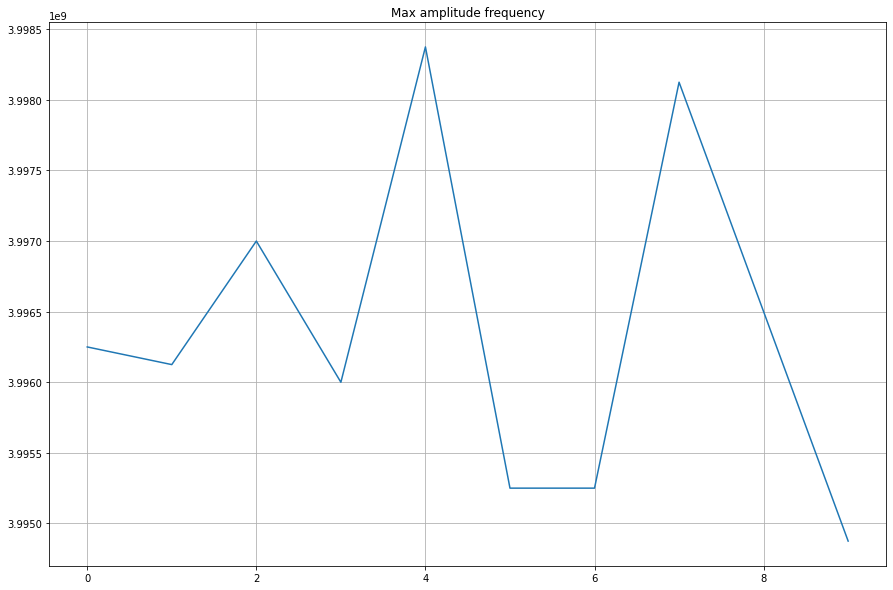

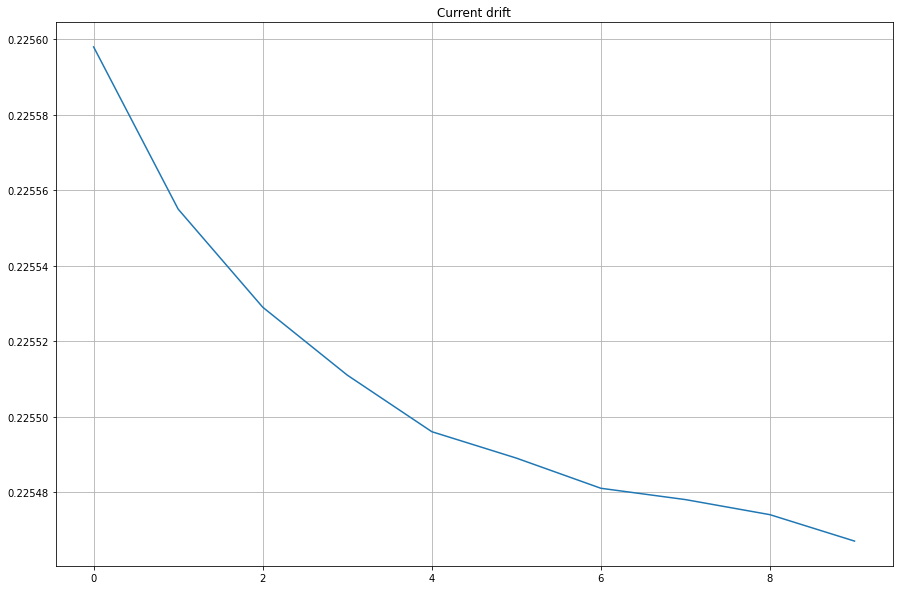

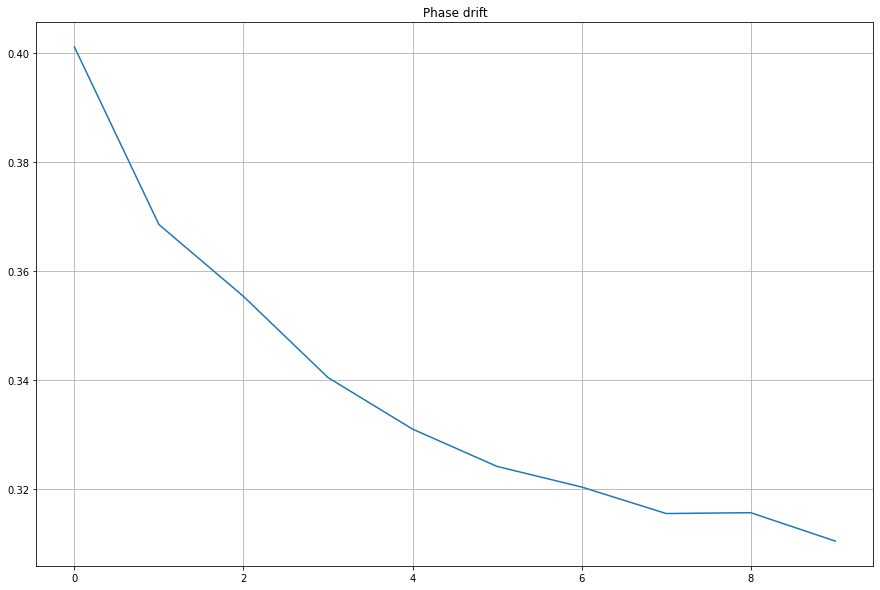

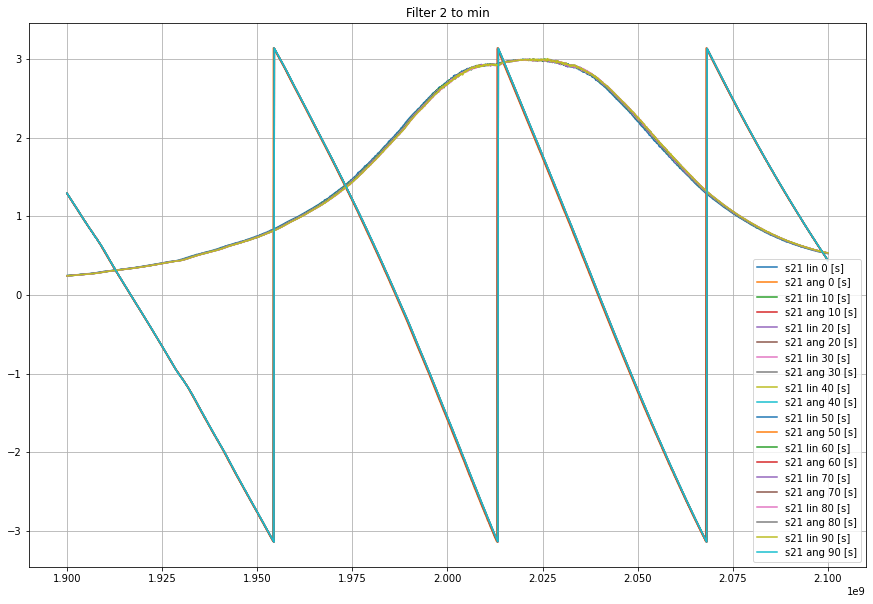

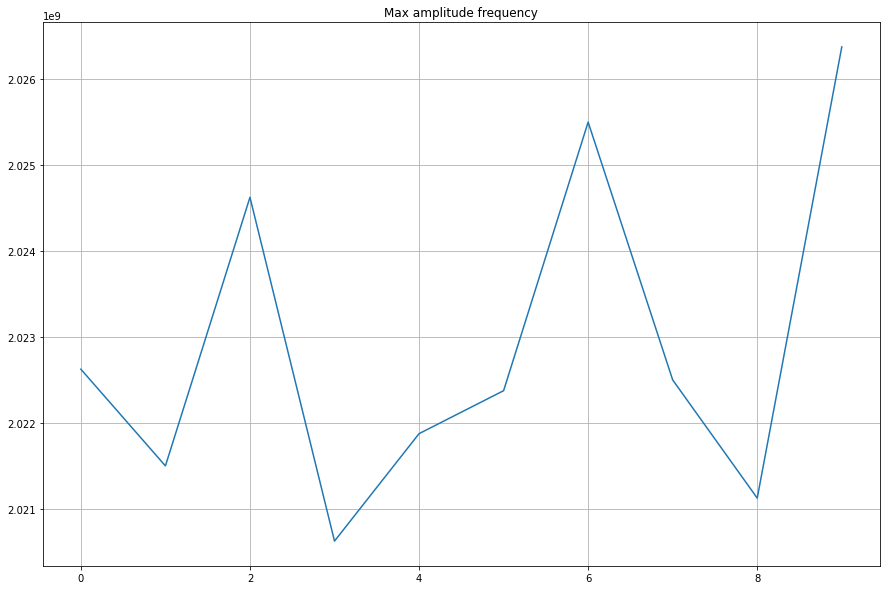

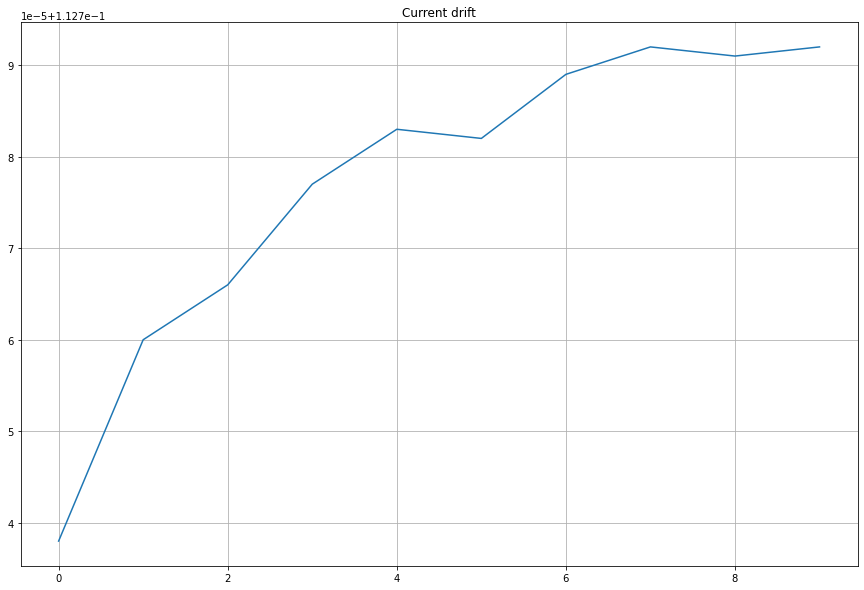

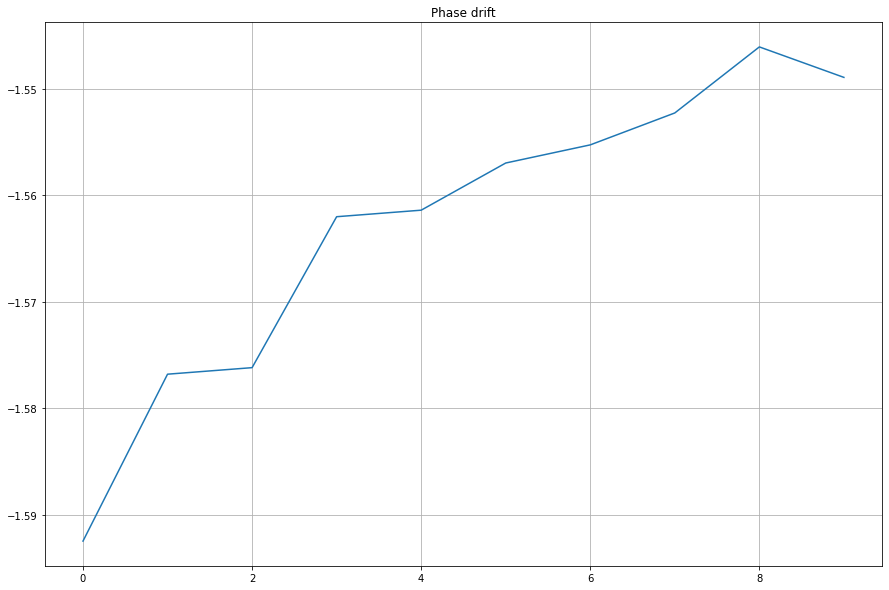

Measuring filter 3


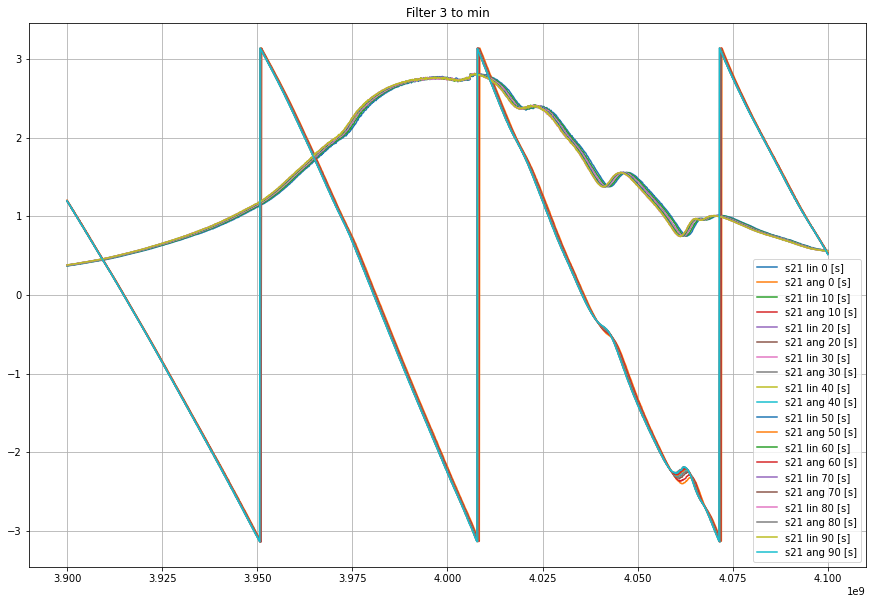

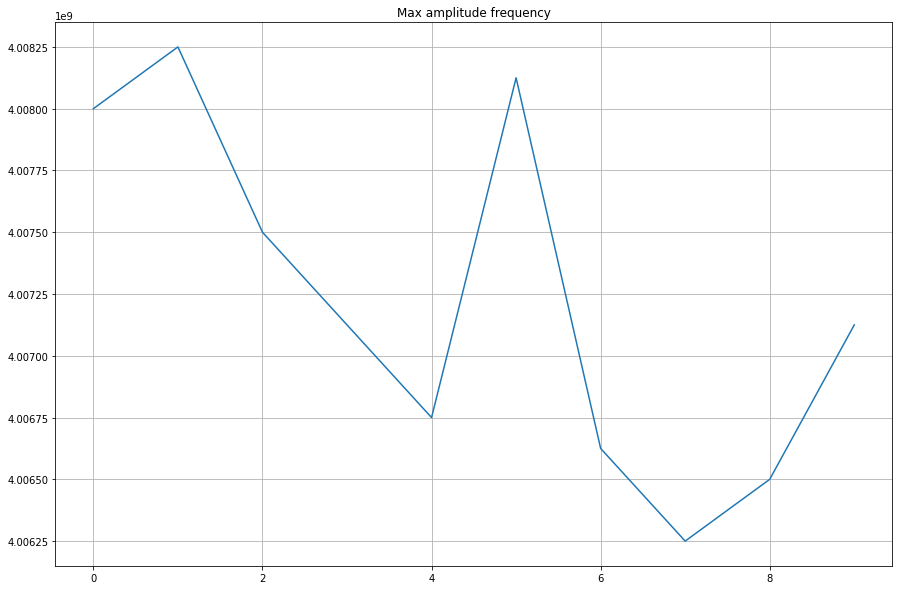

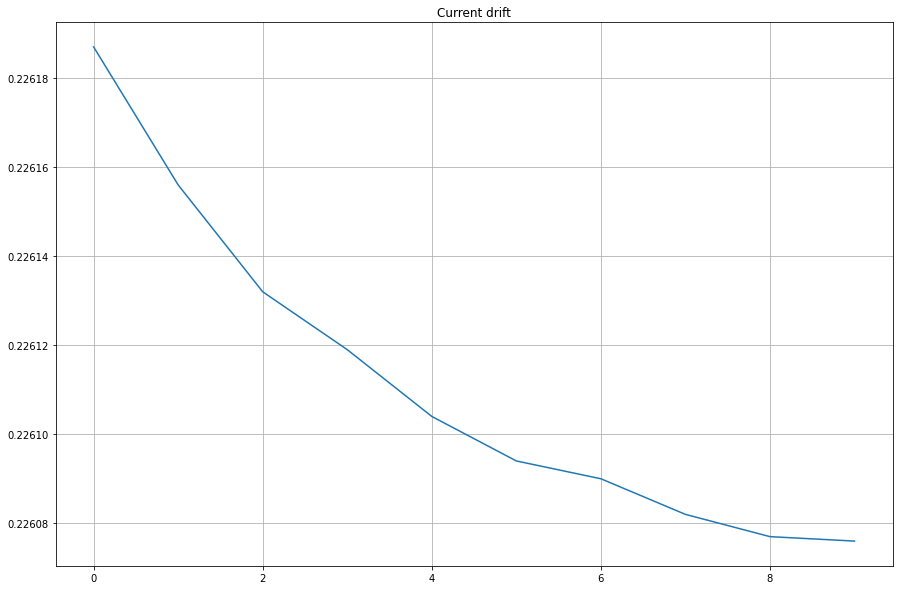

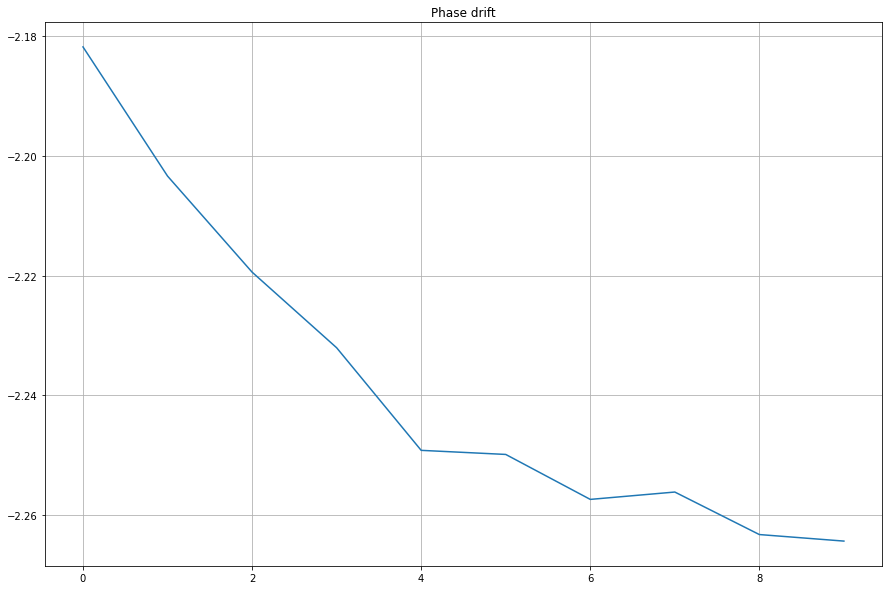

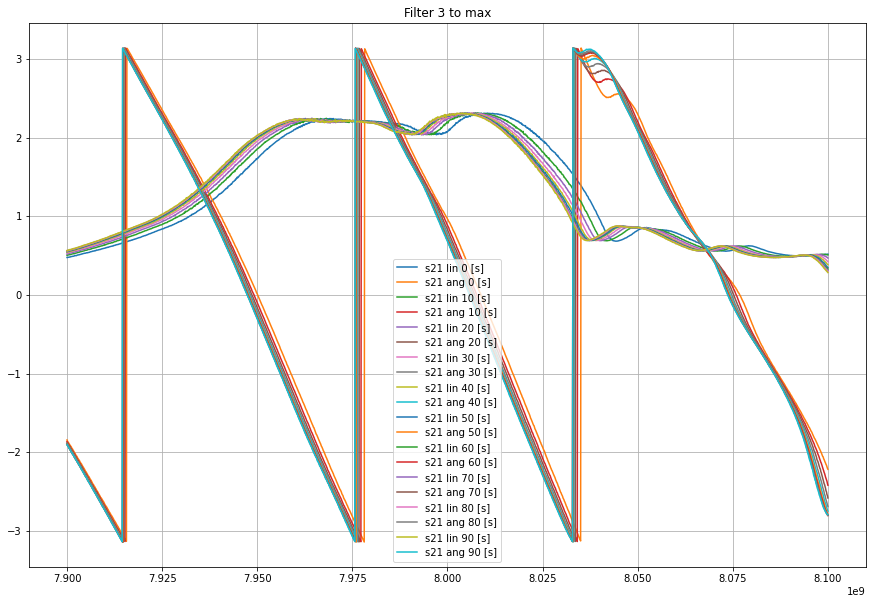

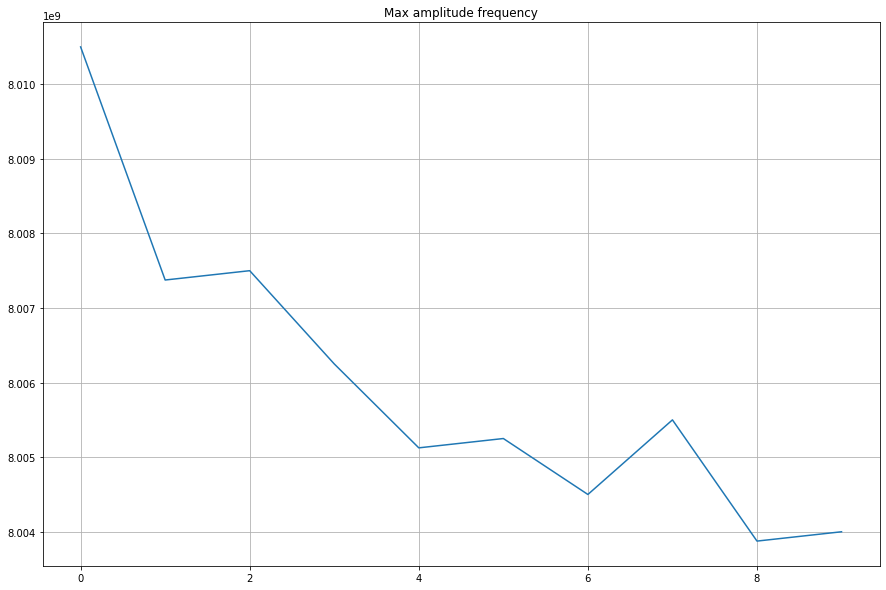

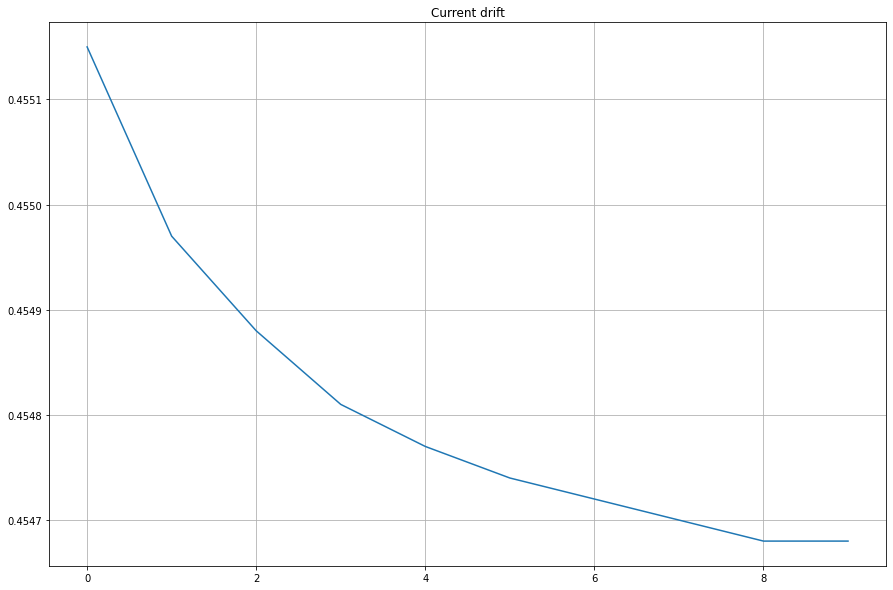

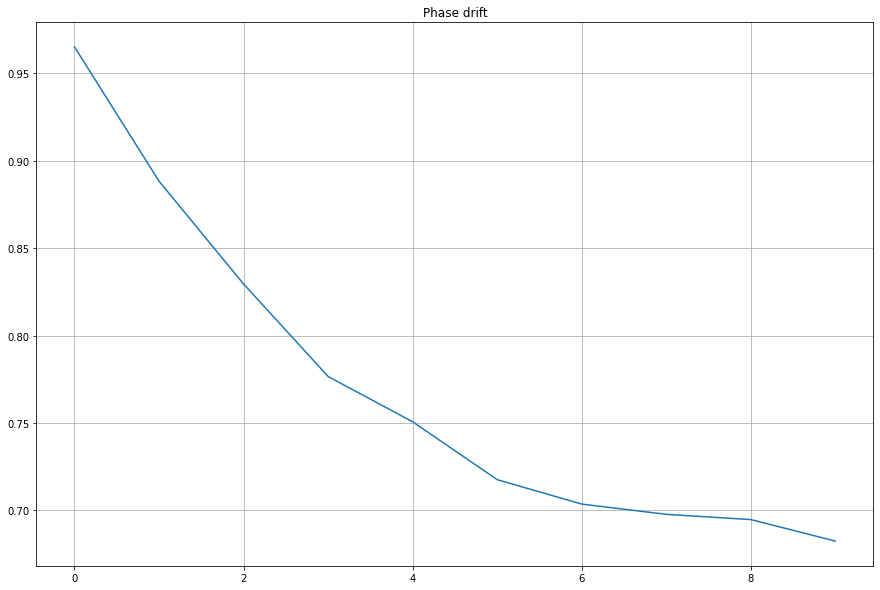

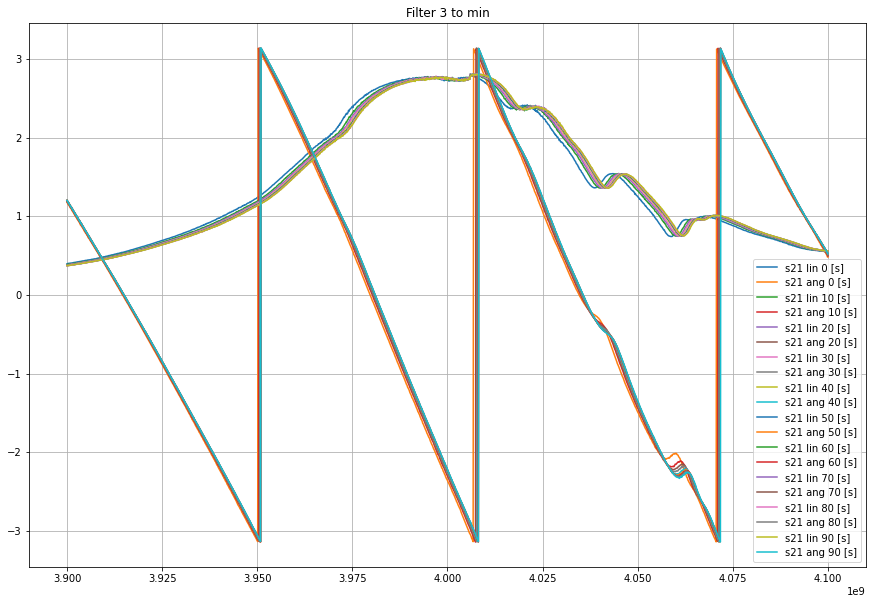

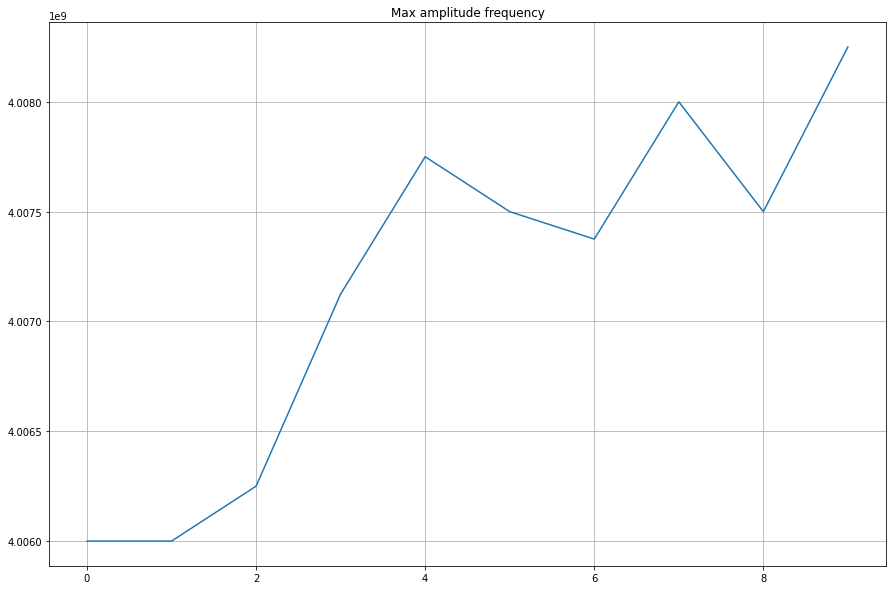

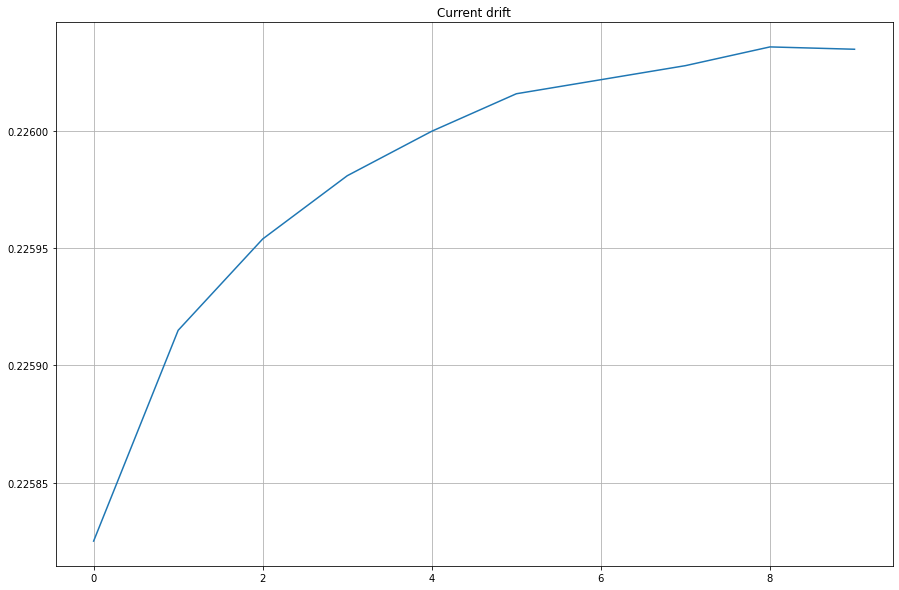

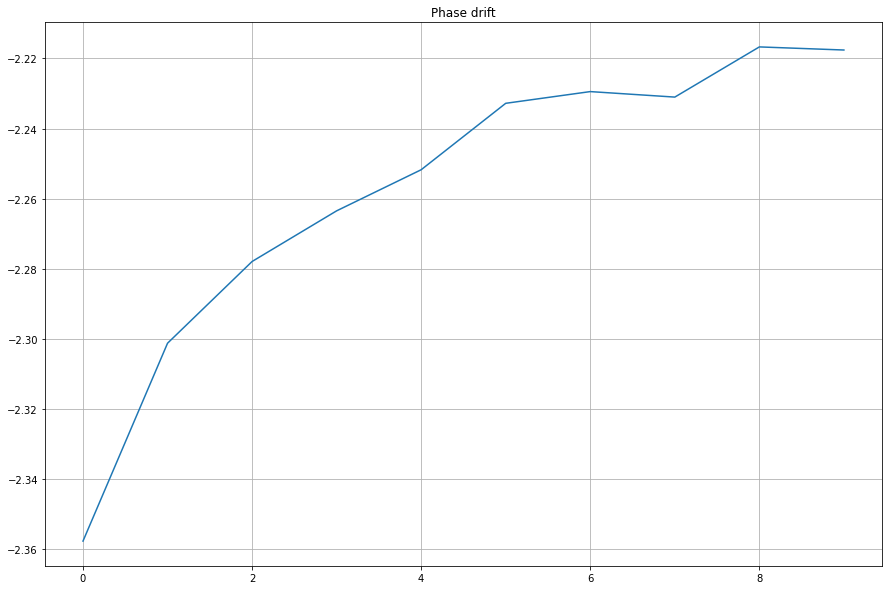

Measuring filter 4


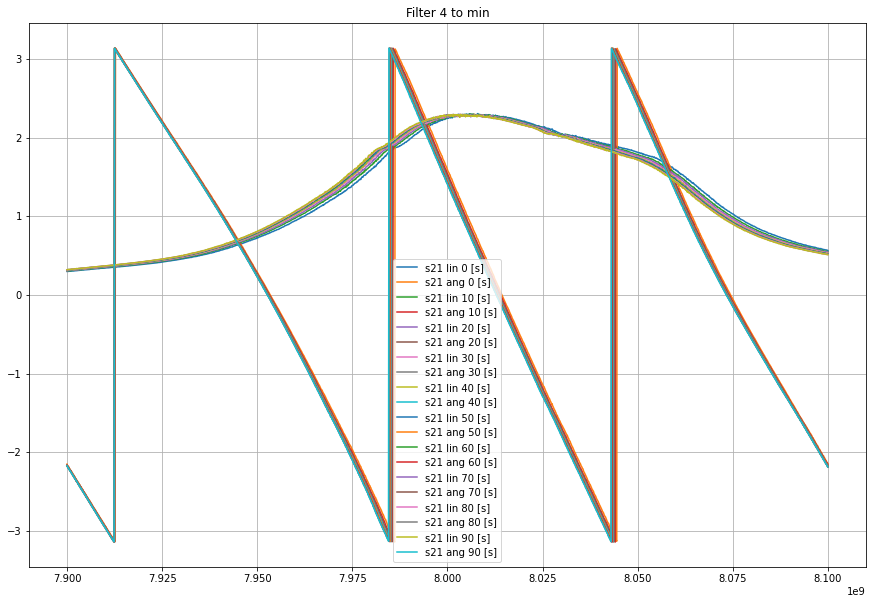

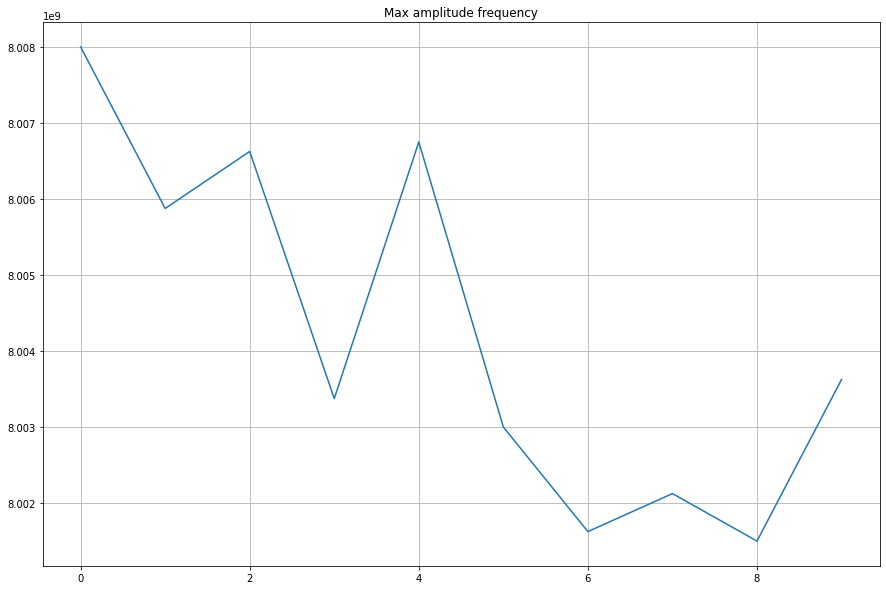

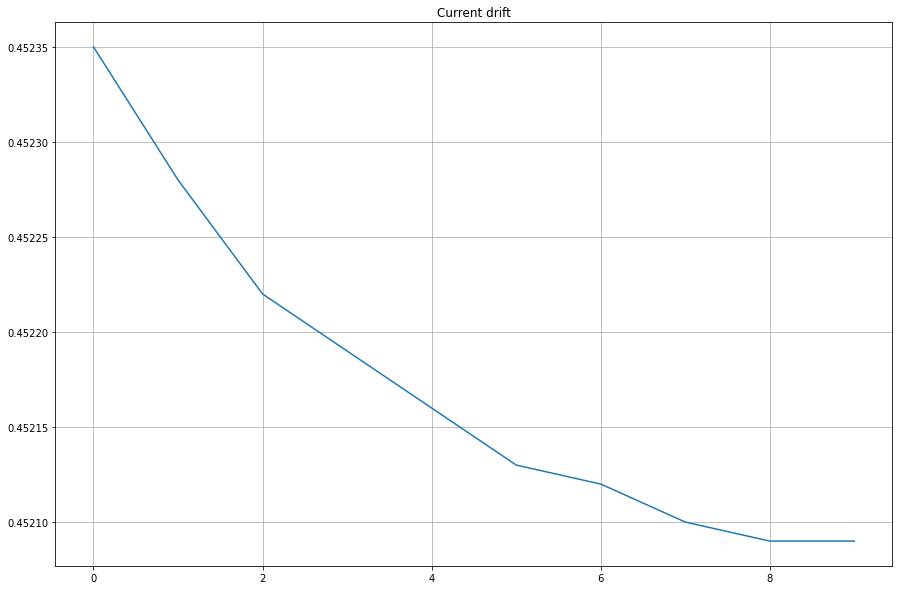

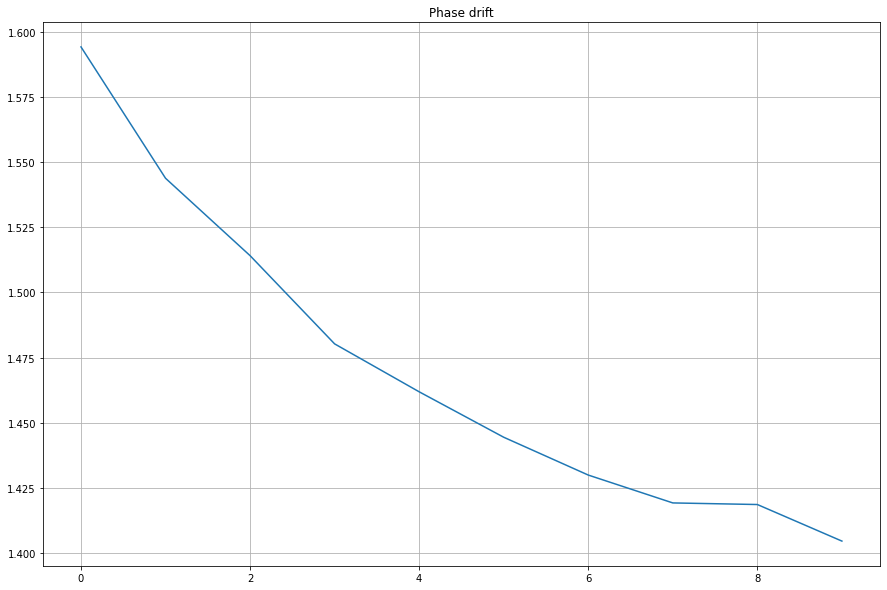

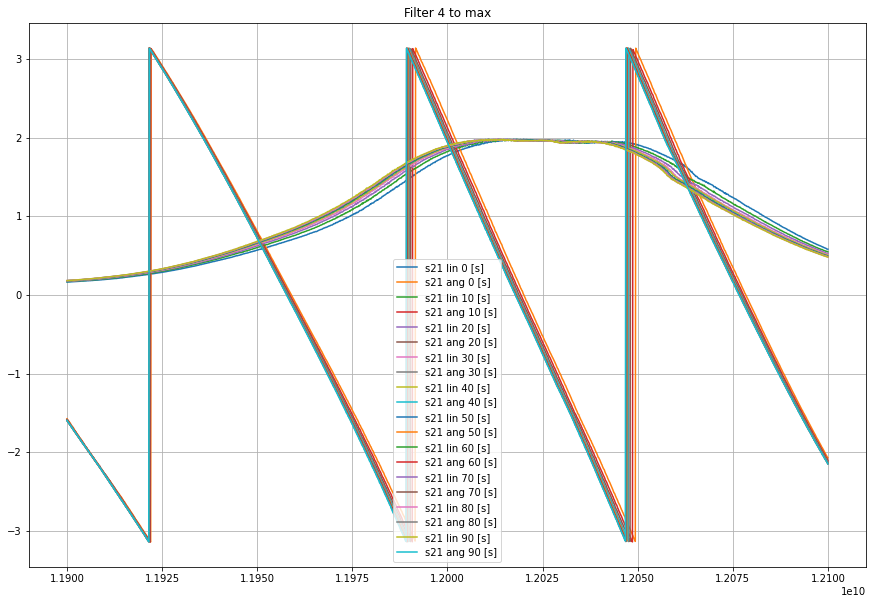

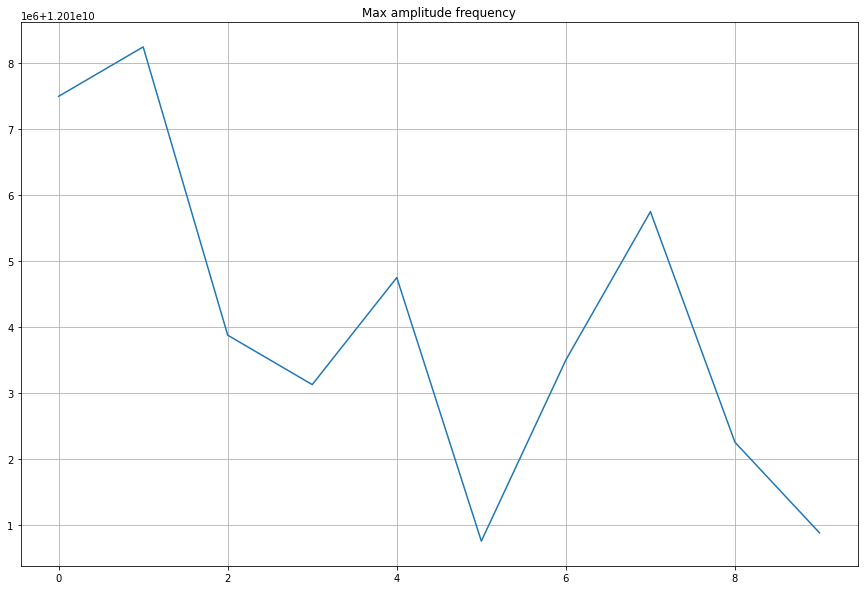

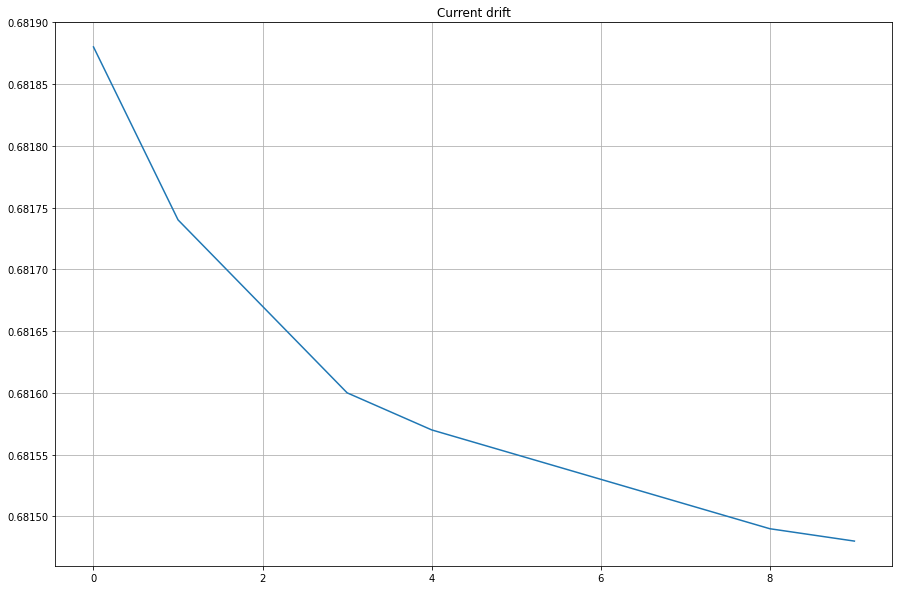

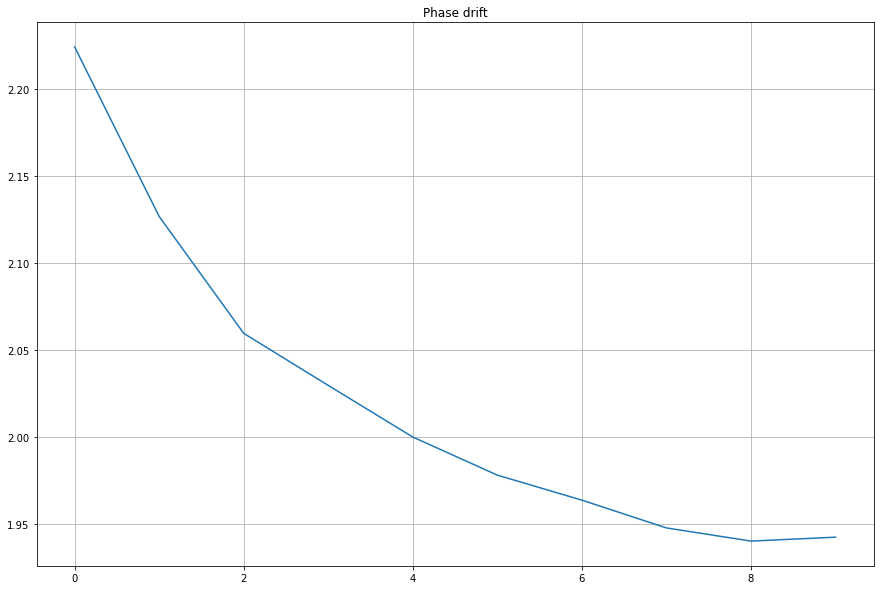

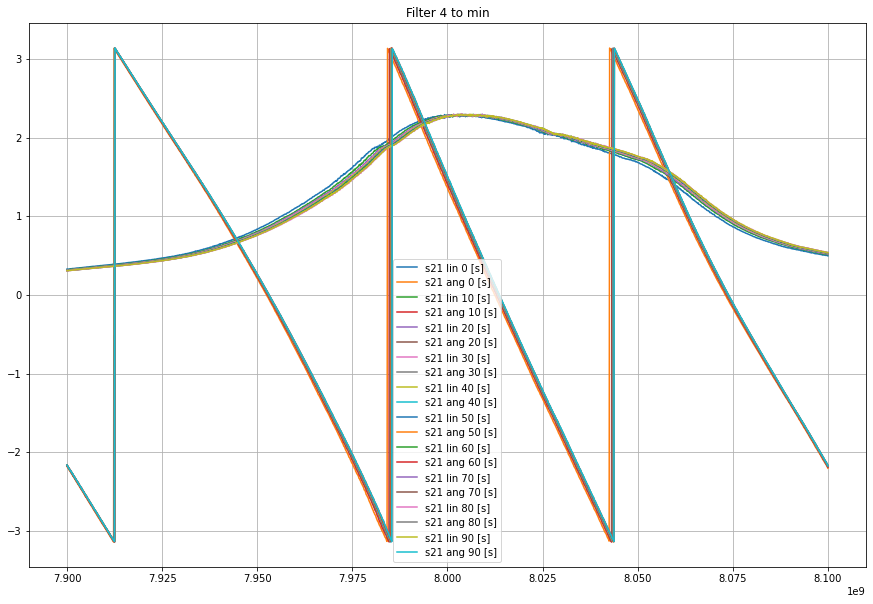

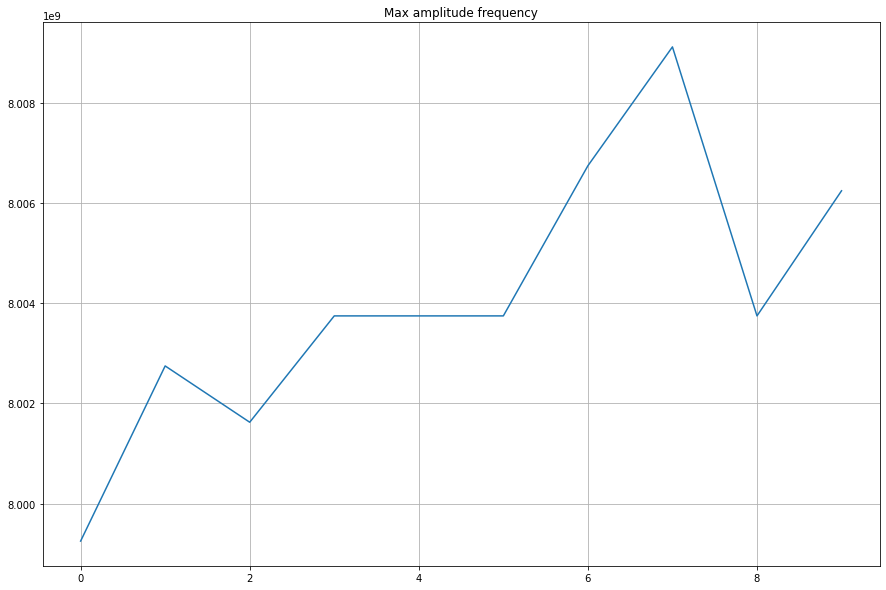

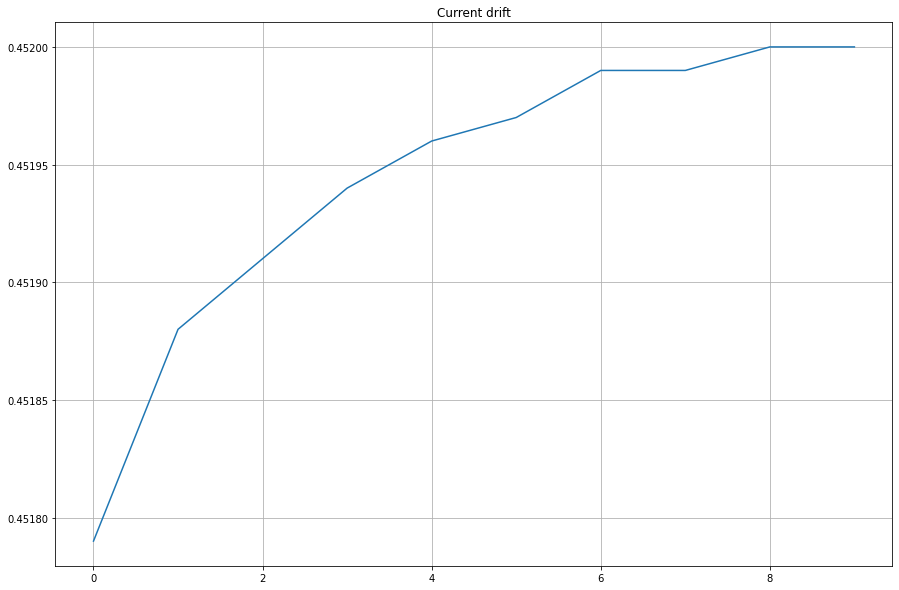

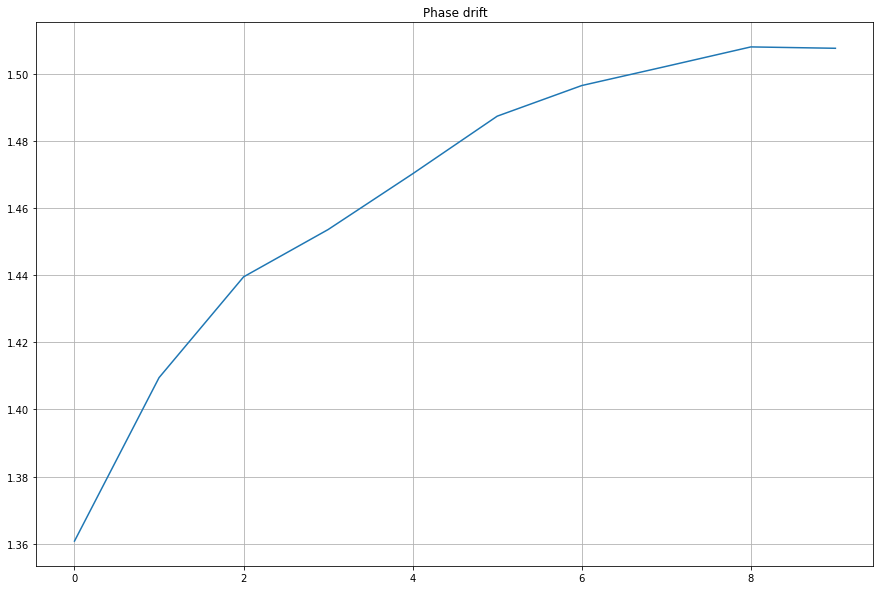

Measuring filter 5


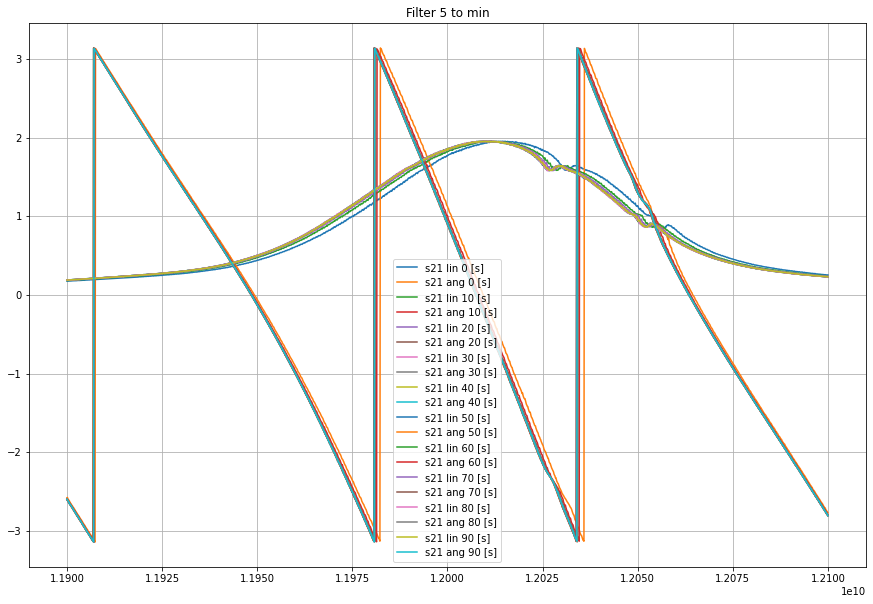

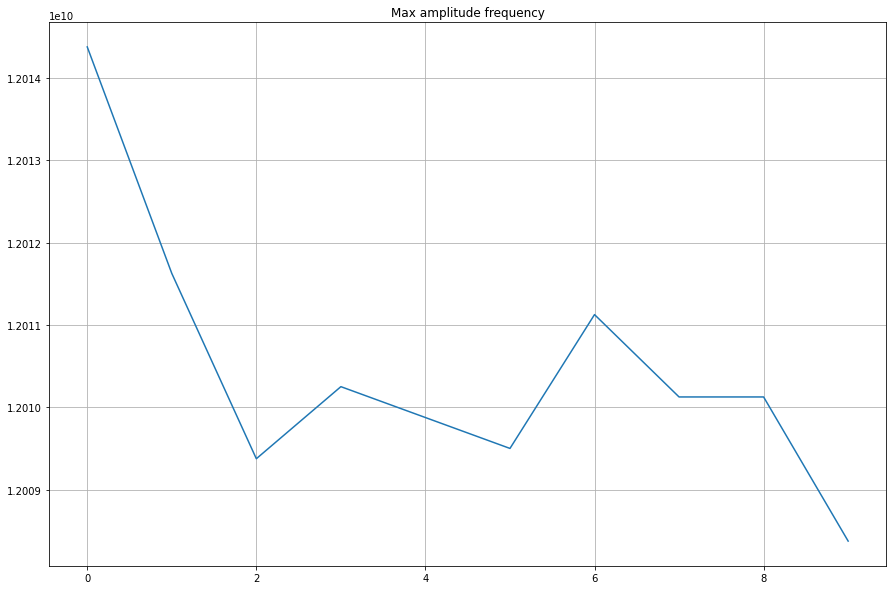

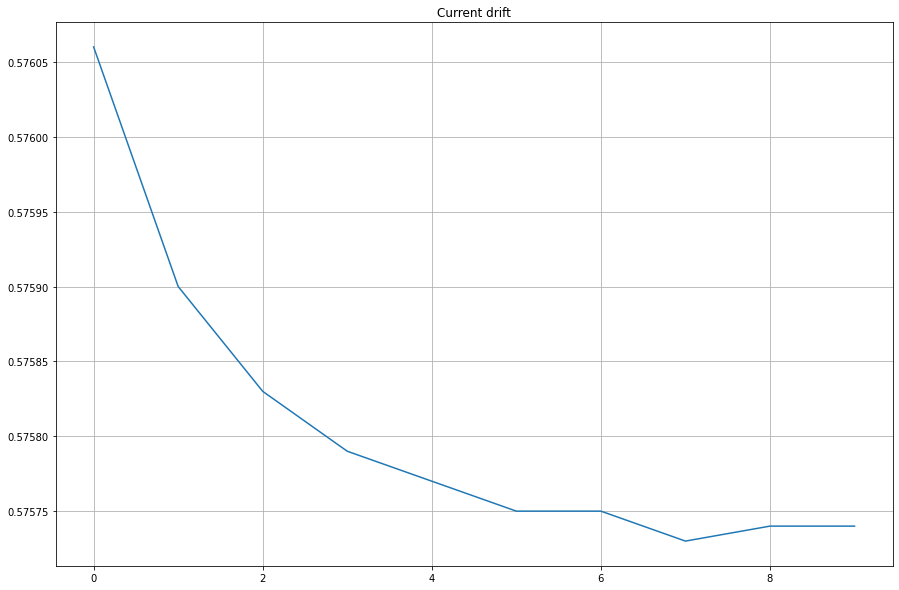

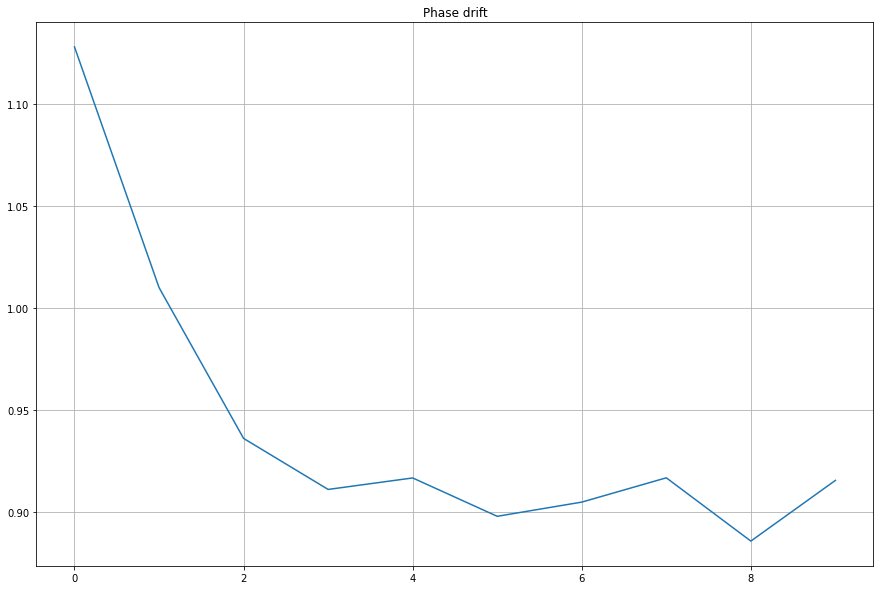

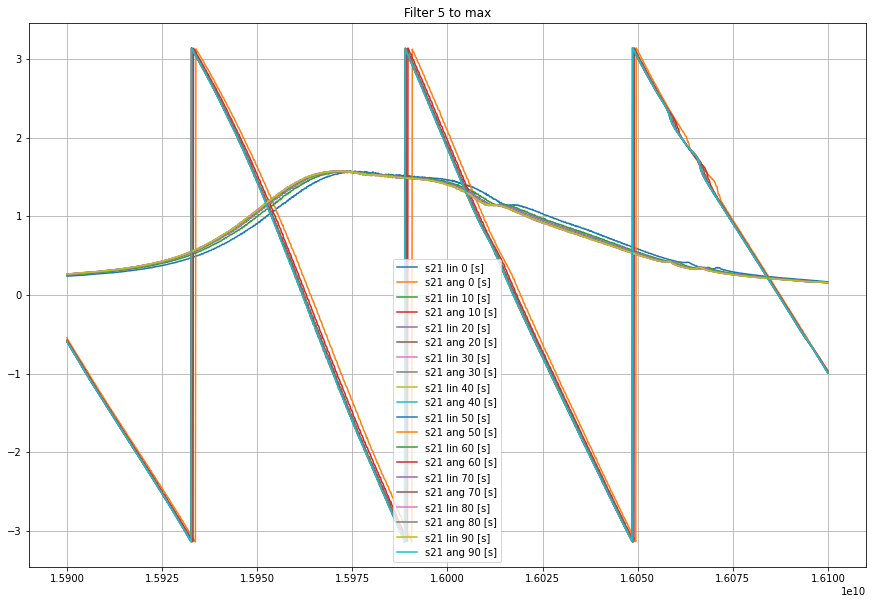

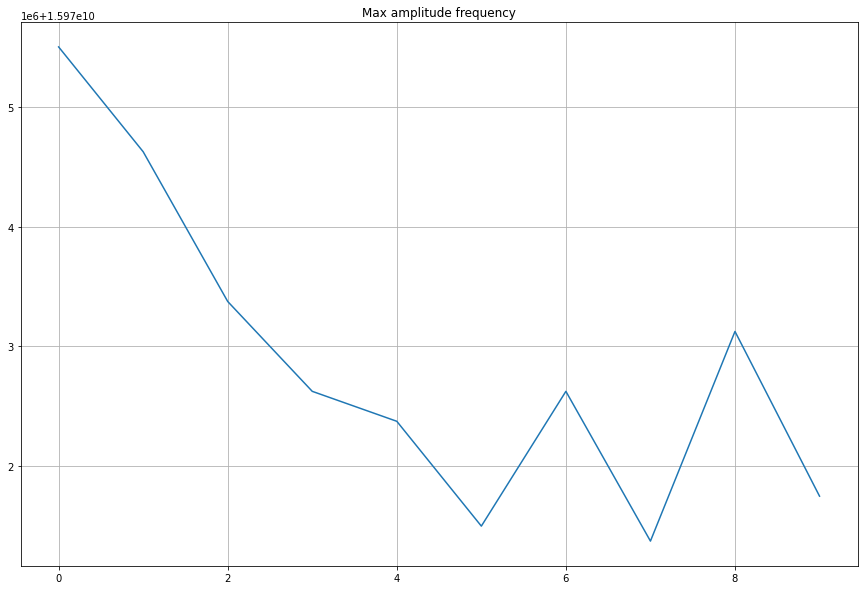

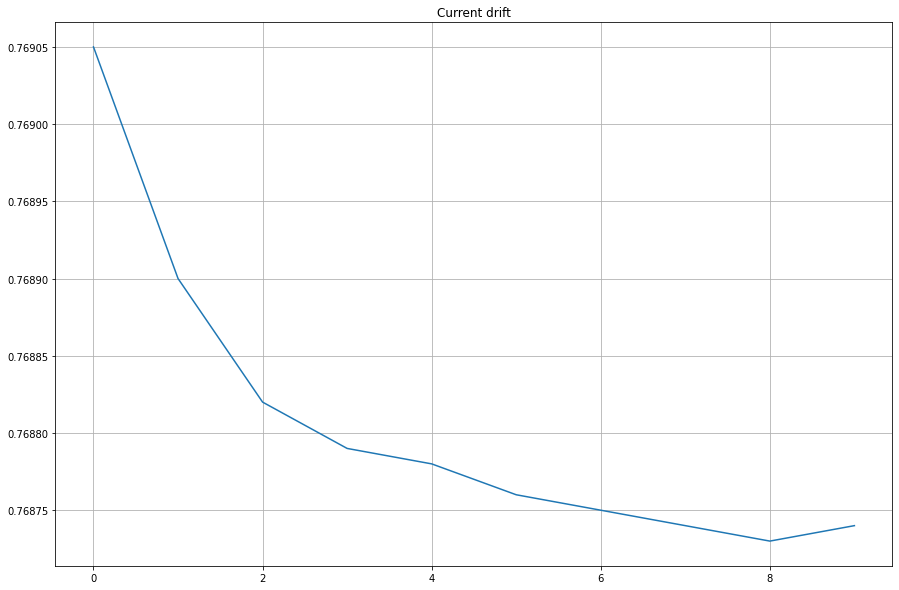

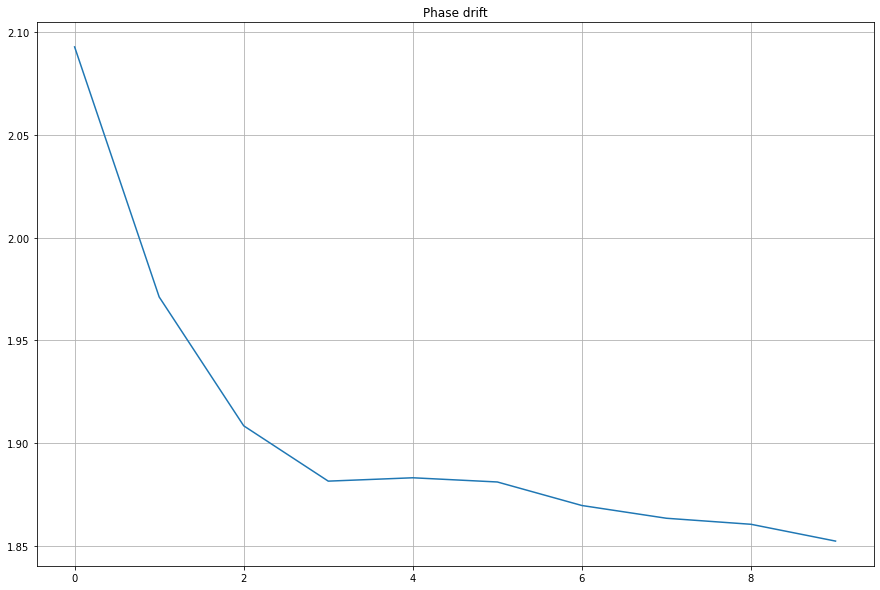

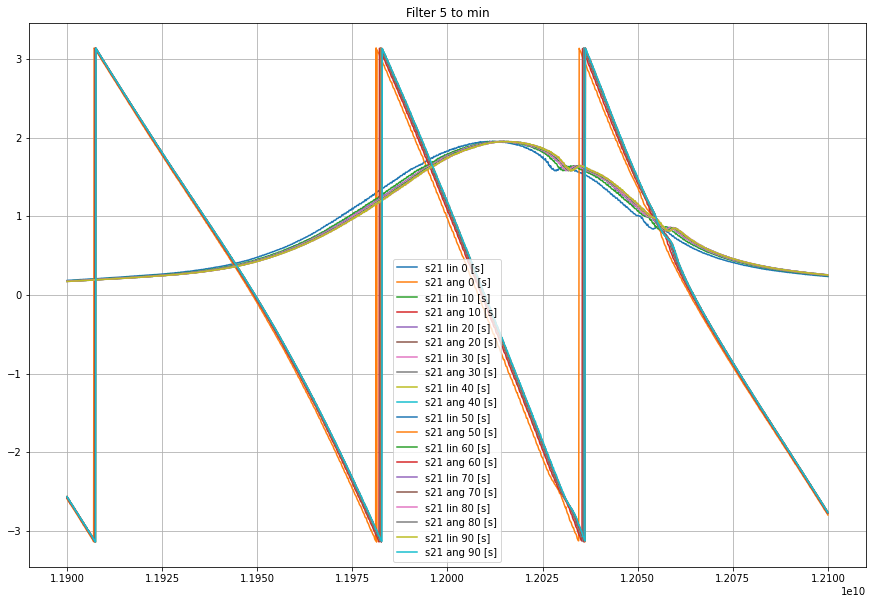

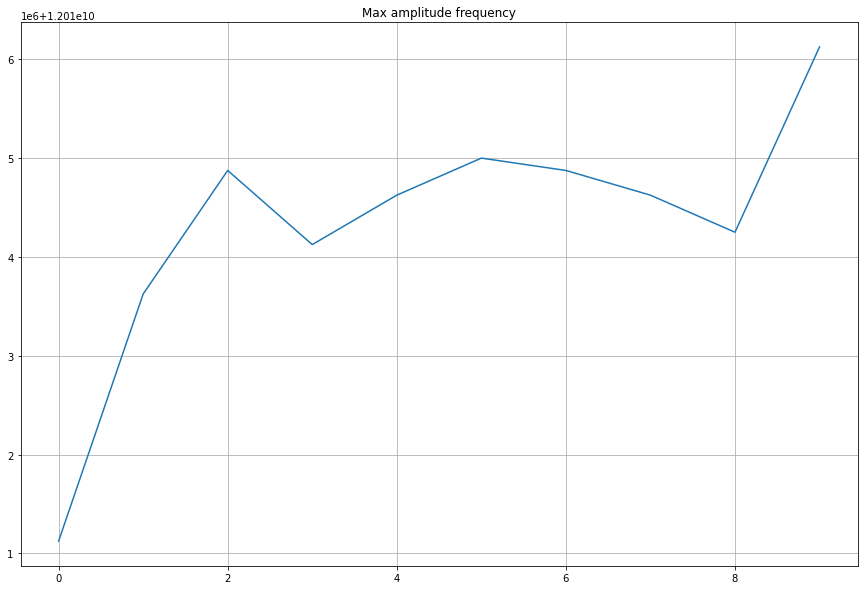

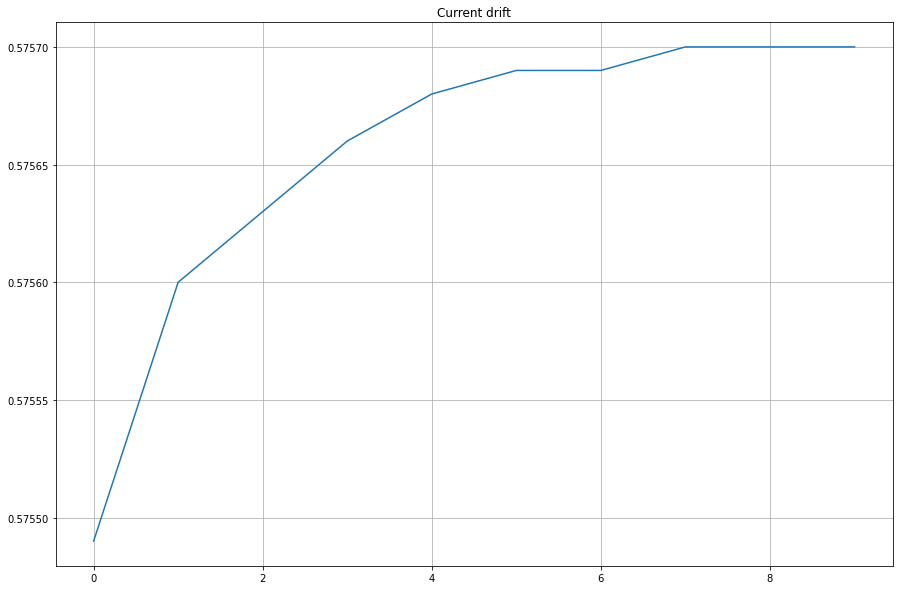

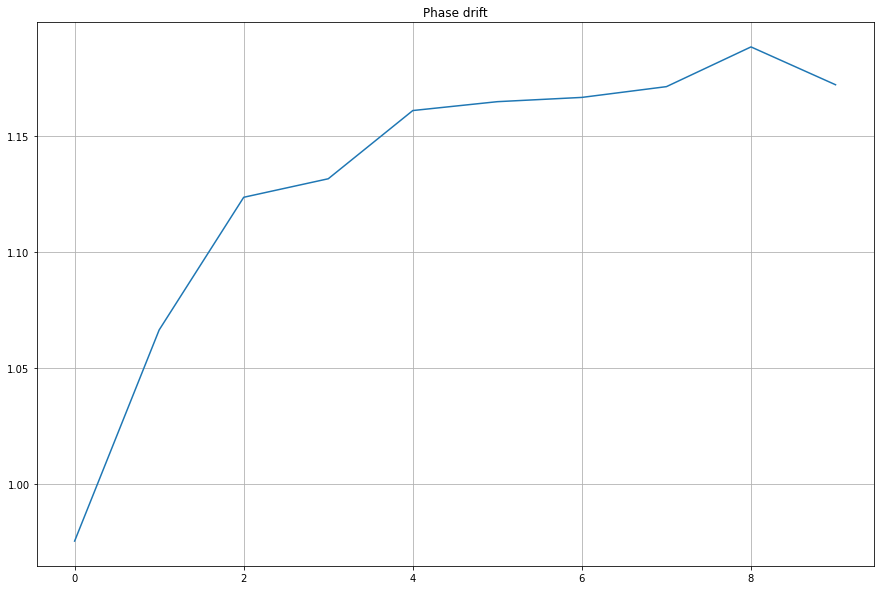

In [16]:
import time
coarseFilter=loadData('coarse_filter_parameters')
mvec=coarseFilter['m'][0]
kvec=coarseFilter['k'][0]


def computeWord(fTarget, k, m):
    return (fTarget/1e6-m)/k

s21Drift=None
currentDrift=None

dataDict={}

for i in range(6):
    print("Measuring filter", i)
    k = kvec[i]
    m = mvec[i]
    yc.switchA.set(i+1)
    yc.yigA.set(i, int(computeWord(fMin[i], k, m)))
    vna.setStartFrequency(fMin[i]-100e6)
    vna.setStopFrequency(fMin[i]+100e6)
    for a in range(10):
        curMeter.readValue()
    t0=time.time()
    t00=t0
    plt.figure()
    fmax=[]
    curr=[]
    phase=[]
    sFreq = None
    sMat = None
    timeVec = []
    keyBase = 'yigFilter%d'%(i)
    for j in range(10):
        
        t0=t00+10*j
        while time.time() < t0:
            pass
        f=vna.frequencies()
        curr.append(curMeter.readValue())
        t=vna.readSParameter('S21')
        fmax.append(f[np.argmax(np.abs(t))])
        phase.append(np.angle(t[int(len(t)/2)]))
        sFreq = f;
        sMat = yig_controller_test.stackVector(sMat, t)
        timeVec.append(t0)
        
        plt.title("Filter %d to min"%(i))
        plt.plot(f, np.abs(t), label="s21 lin %d [s]"%(t0-t00))
        plt.plot(f, np.angle(t), label="s21 ang %d [s]"%(t0-t00))
    dataDict[keyBase+'Low'+'Current']=curr    
    dataDict[keyBase+'Low'+'Time']=timeVec
    dataDict[keyBase+'Low'+'SparFreq']=sFreq
    dataDict[keyBase+'Low'+'sPar']=sMat
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Max amplitude frequency')
    plt.plot(fmax)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Current drift')
    plt.plot(curr)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Phase drift')
    plt.plot(phase)
    plt.grid(True)
    plt.show()
    
    yc.yigA.set(i, int(computeWord(fMax[i], k, m)))
    vna.setStartFrequency(fMax[i]-100e6)
    vna.setStopFrequency(fMax[i]+100e6)
    for a in range(10):
        curMeter.readValue()
    t0=time.time()
    t00=t0
    plt.figure()
    fmax=[]
    curr=[]
    phase=[]
    sFreq = None
    sMat = None
    timeVec = []
    for j in range(10):
        t0=t00+10*j
        while time.time() < t0:
            pass
        f=vna.frequencies()
        curr.append(curMeter.readValue())
        t=vna.readSParameter('S21')
        fmax.append(f[np.argmax(np.abs(t))])
        phase.append(np.angle(t[int(len(t)/2)]))
        sFreq = f;
        sMat = yig_controller_test.stackVector(sMat, t)
        timeVec.append(t0)
        plt.title("Filter %d to max"%(i))
        plt.plot(f, np.abs(t), label="s21 lin %d [s]"%(t0-t00))
        plt.plot(f, np.angle(t), label="s21 ang %d [s]"%(t0-t00))
    dataDict[keyBase+'High'+'Current']=curr    
    dataDict[keyBase+'High'+'Time']=timeVec
    dataDict[keyBase+'High'+'SparFreq']=sFreq
    dataDict[keyBase+'High'+'sPar']=sMat
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Max amplitude frequency')
    plt.plot(fmax)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Current drift')
    plt.plot(curr)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Phase drift')
    plt.plot(phase)
    plt.grid(True)
    plt.show()
    
    
    yc.yigA.set(i, int(computeWord(fMin[i], k, m)))
    vna.setStartFrequency(fMin[i]-100e6)
    vna.setStopFrequency(fMin[i]+100e6)
    for a in range(10):
        curMeter.readValue()
    t0=time.time()
    t00=t0
    plt.figure()
    fmax=[]
    curr=[]
    phase=[]
    sFreq = None
    sMat = None
    timeVec = []
    for j in range(10):
        
        t0=t00+10*j
        while time.time() < t0:
            pass
        f=vna.frequencies()
        curr.append(curMeter.readValue())
        t=vna.readSParameter('S21')
        fmax.append(f[np.argmax(np.abs(t))])
        phase.append(np.angle(t[int(len(t)/2)]))
        sFreq = f;
        sMat = yig_controller_test.stackVector(sMat, t)
        timeVec.append(t0)
        plt.title("Filter %d to min"%(i))
        plt.plot(f, np.abs(t), label="s21 lin %d [s]"%(t0-t00))
        plt.plot(f, np.angle(t), label="s21 ang %d [s]"%(t0-t00))
    dataDict[keyBase+'LowAgain'+'Current']=curr    
    dataDict[keyBase+'LowAgain'+'Time']=timeVec
    dataDict[keyBase+'LowAgain'+'SparFreq']=sFreq
    dataDict[keyBase+'LowAgain'+'sPar']=sMat
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Max amplitude frequency')
    plt.plot(fmax)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Current drift')
    plt.plot(curr)
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.title('Phase drift')
    plt.plot(phase)
    plt.grid(True)
    plt.show()
saveData('filter_drift', dataDict)

## Fine tuning of filter tuning parameters

In [17]:
a = loadData('coarse_filter_parameters')
import yig_controller_test
import yig_filter_model

ks = a['k'][0]
ms = a['m'][0]
filterBank = []
for i in range(len(ks)):
    filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
calMeas = skrf.network.Network('cal_through.s2p')

fix = yig_filter_model.SimpleS21Fixture(calMeas.f, calMeas.s[:, 1, 0])


def measureYigFilter(f):
    frequencies = np.linspace(f.flow, f.fhigh, 101)
    vna.setPoints(201)
    filterMap=None
    spanMap=None
    tuningWords=[]
    for fr in frequencies:
        f.tuneTo(fr)
        tuningWords.append(f.computetTuningWord(fr))
        vna.setStartFrequency(fr-250e6)
        vna.setStopFrequency(fr+250e6)
        spar=vna.readSParameter('S21')
        fax = vna.frequencies()
        spanMap = yig_controller_test.stackVector(spanMap, fax)
        dePar=fix.deembedFrom(fax, spar)
        filterMap=yig_controller_test.stackVector(filterMap, dePar)
    plt.figure()
    plt.imshow(20*np.log10(np.abs(filterMap)))
    plt.colorbar()
    plt.show()
    return filterMap, tuningWords, frequencies, spanMap
        
                             
                             
    

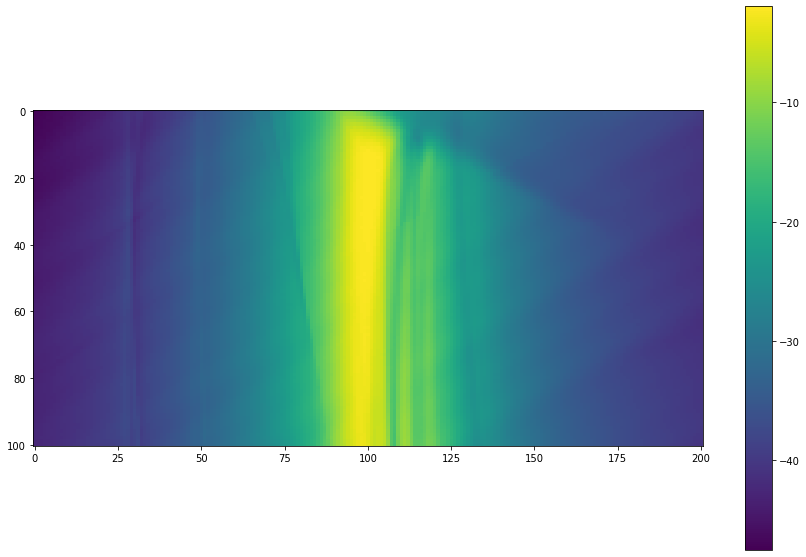

In [18]:
filter0Map, filter0TuningWords, filter0Frequencies, filter0SpanMap = measureYigFilter(filterBank[0])

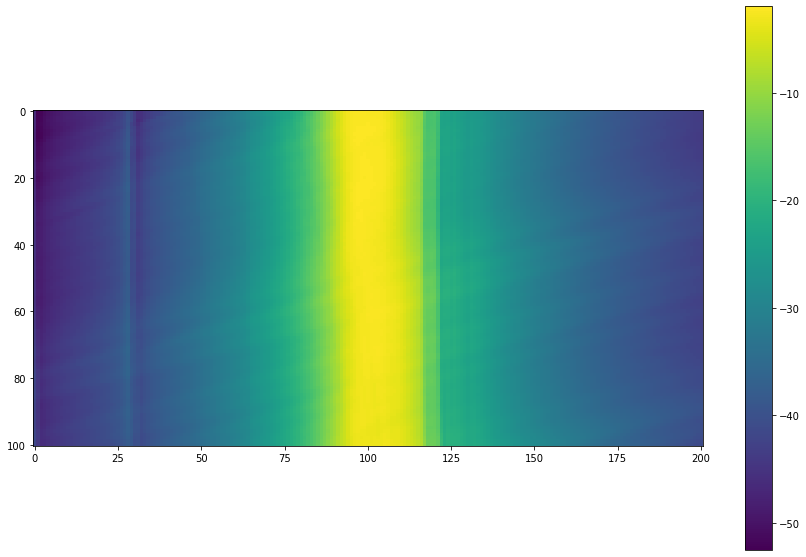

In [19]:
filter1Map, filter1TuningWords, filter1Frequencies, filter1SpanMap = measureYigFilter(filterBank[1])

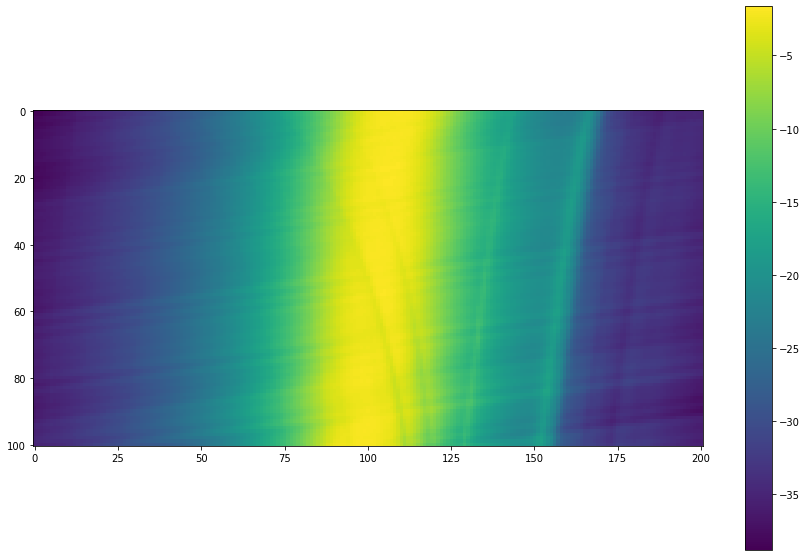

In [20]:
filter2Map, filter2TuningWords, filter2Frequencies, filter2SpanMap = measureYigFilter(filterBank[2])

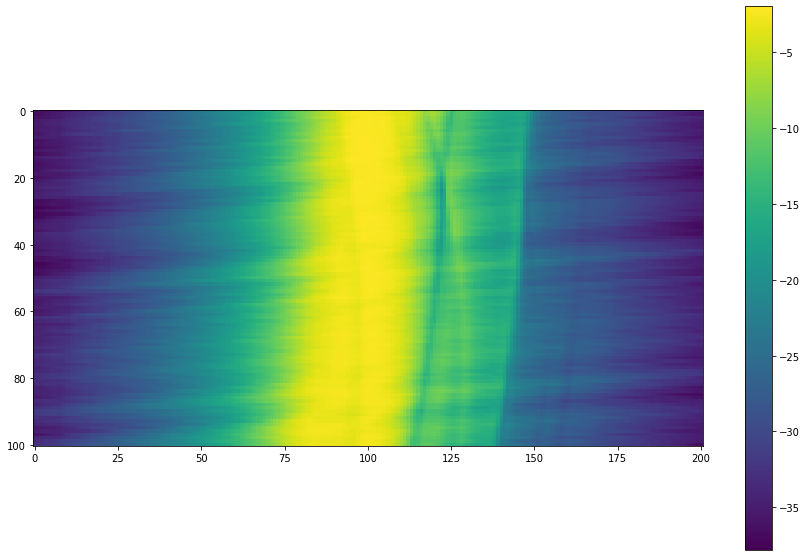

In [21]:
filter3Map, filter3TuningWords, filter3Frequencies, filter3SpanMap = measureYigFilter(filterBank[3])

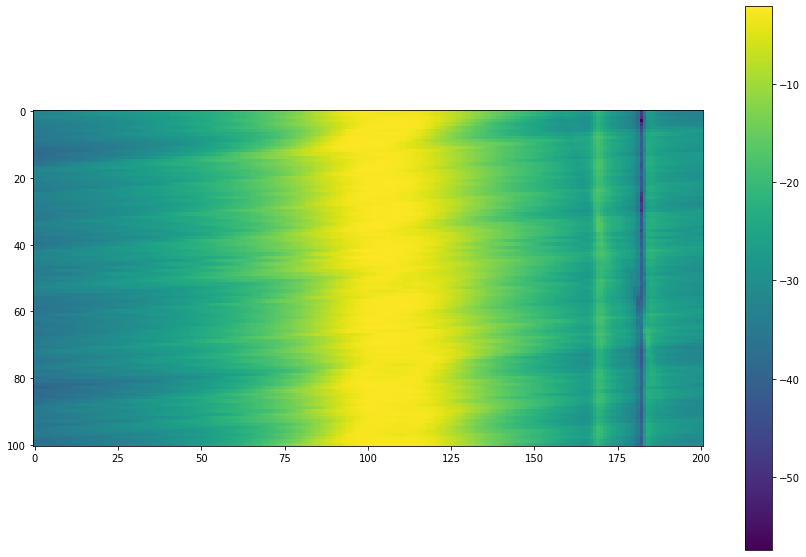

In [23]:
filter4Map, filter4TuningWords, filter4Frequencies, filter4SpanMap = measureYigFilter(filterBank[4])

In [ ]:
filter5Map, filter5TuningWords, filter5Frequencies, filter5SpanMap = measureYigFilter(filterBank[5])

In [ ]:
saveDict={'filter0Map':filter0Map, 'filter0TuningWords':filter0TuningWords, 'filter0Frequencies':filter0Frequencies, 'filter0SpanMap':filter0SpanMap, 
          'filter1Map':filter1Map, 'filter1TuningWords':filter1TuningWords, 'filter1Frequencies':filter1Frequencies, 'filter1SpanMap':filter1SpanMap, 
          'filter2Map':filter2Map, 'filter2TuningWords':filter2TuningWords, 'filter2Frequencies':filter2Frequencies, 'filter2SpanMap':filter2SpanMap, 
          'filter3Map':filter3Map, 'filter3TuningWords':filter3TuningWords, 'filter3Frequencies':filter3Frequencies, 'filter3SpanMap':filter3SpanMap, 
          'filter4Map':filter4Map, 'filter4TuningWords':filter4TuningWords, 'filter4Frequencies':filter4Frequencies, 'filter4SpanMap':filter4SpanMap, 
          'filter5Map':filter5Map, 'filter5TuningWords':filter5TuningWords, 'filter5Frequencies':filter5Frequencies, 'filter5SpanMap':filter5SpanMap, }
saveData('coarse_tuning_fine_measurements', saveDict)